## 1. Import necessary liberaries

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob

import torch
from torch.nn.functional import softmax

import emoji
from cleantext import clean
import preprocessor as p  # tweet-preprocessor

from gensim.parsing.preprocessing import remove_stopwords

from transformers import RobertaTokenizer, RobertaForSequenceClassification

from tqdm import tqdm

# NLTK data download (only if not already downloaded)
def download_nltk_package(package_name, resource_path):
    try:
        nltk.data.find(resource_path)
    except LookupError:
        nltk.download(package_name)

download_nltk_package('vader_lexicon', 'sentiment/vader_lexicon.zip')
download_nltk_package('wordnet', 'corpora/wordnet.zip')
download_nltk_package('omw-1.4', 'corpora/omw-1.4.zip')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

## 2. Load the CSV files into  DataFrames

##### 2.1. Define a function to load the dataset
2.2.1. Load the dataset using the function below

In [2]:
def load_dataset(file_path):
    try:
        # Attempt to load with UTF-8 encoding
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        # Fallback to ISO-8859-1 encoding if UTF-8 fails
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    return df

df = load_dataset('namibia_reviews_tripadvisor.csv')
df.head()

tourist_name             tourist_country  \
0  _christiane_domen_cd            Antwerp, Belgium   
1               _nlrdng               Aylesbury, UK   
2                111Bev  Richards Bay, South Africa   
3             113Sheila         Brisbane, Australia   
4             115arturo                Gijon, Spain   

                                               topic  \
0   Ghost town Kolmanskop 10 km drive from LÃ¼deritz   
1  Great experience. Perfect planning and organis...   
2                                       Just Amazing   
3                                          Very good   
4                                  Travel to Namibia   

                                             reviews visit_date review_date  \
0  We booked a visit to Kolmanskop. You can only ...  23-Aug-19   23-Aug-19   
1  We had a great time. The organisation of the w...  15-Dec-22   15-Dec-22   
2  Deadvlei is definitely a highlight of Sossusvl...  29-May-17   29-May-17   
3  Wonderful place to wander around and try to im...  21-May-14   21-May-14   
4  Namibia Tours & Safaris organized very well ou...  14-Oct-16   14-Oct-16   

  tourist_type               reviewed_place  
0      Friends                  Epupa Falls  
1      Friends          Okaukuejo waterhole  
2      Friends  Daan Viljoen Nature Reserve  
3      Couples                     Namutoni  
4      Couples          Okaukuejo waterhole

## 3. Data Cleaning and Preprocessing

##### Step 1: Drop the first column which appears to be an ID or redundant column

In [3]:
df.drop(columns=[df.columns[0]], inplace=True)

##### Step 2: Create new review Id column

In [4]:
df['Id'] = range(1, len(df) + 1) # This creates a column titled Id, that starts at 1 and is the length of the DataFrame.
first_column = df.pop('Id')

df.insert(0, 'Id', first_column) #This makes the newly created column the first in the dataframe.

df.head()

Id             tourist_country  \
0   1            Antwerp, Belgium   
1   2               Aylesbury, UK   
2   3  Richards Bay, South Africa   
3   4         Brisbane, Australia   
4   5                Gijon, Spain   

                                               topic  \
0   Ghost town Kolmanskop 10 km drive from LÃ¼deritz   
1  Great experience. Perfect planning and organis...   
2                                       Just Amazing   
3                                          Very good   
4                                  Travel to Namibia   

                                             reviews visit_date review_date  \
0  We booked a visit to Kolmanskop. You can only ...  23-Aug-19   23-Aug-19   
1  We had a great time. The organisation of the w...  15-Dec-22   15-Dec-22   
2  Deadvlei is definitely a highlight of Sossusvl...  29-May-17   29-May-17   
3  Wonderful place to wander around and try to im...  21-May-14   21-May-14   
4  Namibia Tours & Safaris organized very well ou...  14-Oct-16   14-Oct-16   

  tourist_type               reviewed_place  
0      Friends                  Epupa Falls  
1      Friends          Okaukuejo waterhole  
2      Friends  Daan Viljoen Nature Reserve  
3      Couples                     Namutoni  
4      Couples          Okaukuejo waterhole

##### Step 2: Define a comprehensive mapping dictionary for abbreviated countries

In [5]:
country_mapping = {
    'UK': 'United Kingdom',
    'U.K.': 'United Kingdom',
    'GB': 'United Kingdom',
    'USA': 'United States',
    'U.S.A': 'United States',
    'US': 'United States',
    'DC': 'United States',
    'D.C.': 'United States',
    'CA (USA)': 'United States',
    'CA': 'California, United States',
    'NY': 'New York, United States',
    'TX': 'Texas, United States',
    'FL': 'Florida, United States',
    'NJ': 'New Jersey, United States',
    'PA': 'Pennsylvania, United States',
    'IL': 'Illinois, United States',
    'GA': 'Georgia, United States',
    'OH': 'Ohio, United States',
    'NC': 'North Carolina, United States',
    'MI': 'Michigan, United States',
    'MN': 'Minnesota, United States',
    'AZ': 'Arizona, United States',
    'IN': 'Indiana, United States',
    'WA': 'Washington, United States',
    'WI': 'Wisconsin, United States',
    'OR': 'Oregon, United States',
    'MD': 'Maryland, United States',
    'VA': 'Virginia, United States',
    'MA': 'Massachusetts, United States',
    'CO': 'Colorado, United States',
    'UT': 'Utah, United States',
    'NV': 'Nevada, United States',
    'MO': 'Missouri, United States',
    'AL': 'Alabama, United States',
    'AK': 'Alaska, United States',
    'MT': 'Montana, United States',
    'NE': 'Nebraska, United States',
    'NH': 'New Hampshire, United States',
    'NM': 'New Mexico, United States',
    'ND': 'North Dakota, United States',
    'SD': 'South Dakota, United States',
    'VT': 'Vermont, United States',
    'WY': 'Wyoming, United States',
    'IA': 'Iowa, United States',
    'ID': 'Idaho, United States',
    'ME': 'Maine, United States',
    'LA': 'Louisiana, United States',
    'DE': 'Delaware, United States',
    'AR': 'Arkansas, United States',
    'MS': 'Mississippi, United States',
    'OK': 'Oklahoma, United States',
    'KS': 'Kansas, United States',
    'KY': 'Kentucky, United States',
    'RI': 'Rhode Island, United States',
    'SC': 'South Carolina, United States',
    'TN': 'Tennessee, United States',
    'CT': 'Connecticut, United States',
    'AB': 'Alberta, Canada',
    'ON': 'Ontario, Canada',
    'BC': 'British Columbia, Canada',
    'NSW': 'New South Wales, Australia',
    'NZ': 'New Zealand',
    'UAE': 'United Arab Emirates',
    'DRC': 'Democratic Republic of the Congo',
    'SA': 'South Africa',
    'S A': 'South Africa',
    'TLV': 'Israel',
}

##### Step 3: Extract the country from "City, Country" and standardize abbreviations

In [6]:
df['tourist_country'] = df['tourist_country'].str.split(',').str[-1].str.strip()
df['tourist_country'] = df['tourist_country'].replace(country_mapping)

# Display the entire DataFrame after cleaning tourist_country
df.reset_index(drop=True, inplace=True)
df

Id tourist_country                                              topic  \
0        1         Belgium   Ghost town Kolmanskop 10 km drive from LÃ¼deritz   
1        2  United Kingdom  Great experience. Perfect planning and organis...   
2        3    South Africa                                       Just Amazing   
3        4       Australia                                          Very good   
4        5           Spain                                  Travel to Namibia   
...    ...             ...                                                ...   
3666  3667    South Africa                                    Give them a try   
3667  3668          Jaipur                                       Dissapointed   
3668  3669    South Africa                 5 Star facilities - 3 star service   
3669  3670  United Kingdom            San Karos - Poor food, terrible service   
3670  3671  United Kingdom                                            Outdoor   

                                                reviews visit_date  \
0     We booked a visit to Kolmanskop. You can only ...  23-Aug-19   
1     We had a great time. The organisation of the w...  15-Dec-22   
2     Deadvlei is definitely a highlight of Sossusvl...  29-May-17   
3     Wonderful place to wander around and try to im...  21-May-14   
4     Namibia Tours & Safaris organized very well ou...  14-Oct-16   
...                                                 ...        ...   
3666  I stayed for 2 nights on business trip. Very n...  31-Dec-16   
3667  Could not see any animals . The drive is not s...  31-Jan-16   
3668  10 out of 10 for decor, finishings and charact...  31-Jul-16   
3669  We went here on a Sunday for coffee and cake. ...  31-Mar-16   
3670  In the past it has been a disaster.  Resently,...  31-Oct-22   

     review_date tourist_type               reviewed_place  
0      23-Aug-19      Friends                  Epupa Falls  
1      15-Dec-22      Friends          Okaukuejo waterhole  
2      29-May-17      Friends  Daan Viljoen Nature Reserve  
3      21-May-14      Couples                     Namutoni  
4      14-Oct-16      Couples          Okaukuejo waterhole  
...          ...          ...                          ...  
3666   31-Dec-16     Business                 Namib Desert  
3667   31-Jan-16         Solo                   Spitzkoppe  
3668   31-Jul-16     Business      Waterberg National Park  
3669   31-Mar-16      Friends          Okaukuejo waterhole  
3670   31-Oct-22         Solo          Okaukuejo waterhole  

[3671 rows x 8 columns]

##### Step 4: Check for missing values

In [7]:
missing_values = df.isnull().sum().sum()

if missing_values > 0:
    print(f"There are {missing_values} missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")

There are 15 missing values in the DataFrame.


##### Step 5: Format  'visit_date' column into proper date formats
Subsequently create a columns that identifies what the day of the week, Month, and Year the tourist visited.

In [8]:
# Now let's format  'review_date' and 'review_date' column into proper date formats
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%d-%b-%y', errors='coerce')
df['review_date'] = pd.to_datetime(df['review_date'], format='%d-%b-%y', errors='coerce')

# Extract the Weekday from 'visit_date'
df["WeekDay"] = df['visit_date'].dt.day_name()

# Order the Weekdays from Sunday to Saturday
df['WeekDay'] = pd.Categorical(df['WeekDay'], 
                                   categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                                   ordered=True)

# Extract the Month from 'visit_date'
df["Month"] = df['visit_date'].dt.month_name()

# Order the Months from January to December
df['Month'] = pd.Categorical(df['Month'], 
                                 categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                                 ordered=True)

# Extract the Year from 'visit_date' and convert it to integer format
df["Year"] = df['visit_date'].dt.year.astype('Int64')  # Ensure correct integer format for the year column

# Display the cleaned TripAdvisor dataset and the formatted columns in both datasets
df.head()

Id tourist_country                                              topic  \
0   1         Belgium   Ghost town Kolmanskop 10 km drive from LÃ¼deritz   
1   2  United Kingdom  Great experience. Perfect planning and organis...   
2   3    South Africa                                       Just Amazing   
3   4       Australia                                          Very good   
4   5           Spain                                  Travel to Namibia   

                                             reviews visit_date review_date  \
0  We booked a visit to Kolmanskop. You can only ... 2019-08-23  2019-08-23   
1  We had a great time. The organisation of the w... 2022-12-15  2022-12-15   
2  Deadvlei is definitely a highlight of Sossusvl... 2017-05-29  2017-05-29   
3  Wonderful place to wander around and try to im... 2014-05-21  2014-05-21   
4  Namibia Tours & Safaris organized very well ou... 2016-10-14  2016-10-14   

  tourist_type               reviewed_place    WeekDay     Month  Year  
0      Friends                  Epupa Falls     Friday    August  2019  
1      Friends          Okaukuejo waterhole   Thursday  December  2022  
2      Friends  Daan Viljoen Nature Reserve     Monday       May  2017  
3      Couples                     Namutoni  Wednesday       May  2014  
4      Couples          Okaukuejo waterhole     Friday   October  2016

##### Step 7: Remove unwanted characters (emojis, URLS etc.) from the content of reviews
Stopwords will not be remove because research has shown that doing so reduces the ability to properly classify the text. The preprocessed reviews in a column called PreprocessedReviews.

In [9]:
# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Step 1: Preprocess raw review (remove emoji + URLs)
def preprocess_reviews(row): 
    text = row['reviews']
    
    # Remove emojis
    text = remove_emojis(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    return text

# Step 2: Further clean the text (normalize)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    text = remove_stopwords(text)
    return text

# Apply both steps
df['PreprocessedReviews'] = df.apply(preprocess_reviews, axis=1)
df['CleanedReviews'] = df['PreprocessedReviews'].apply(clean_text)

##### Step 8: Check for missing values again

In [10]:
print(df.isnull().sum())

Id                      0
tourist_country         0
topic                   0
reviews                 0
visit_date              0
review_date             0
tourist_type           15
reviewed_place          0
WeekDay                 0
Month                   0
Year                    0
PreprocessedReviews     0
CleanedReviews          0
dtype: int64


###### 8.1. Investigate the Missing Values

In [11]:
df[df['tourist_type'].isnull()].head()

Id tourist_country                                              topic  \
397    398           Italy                               Wonderful experience   
866    867         England            Namibia Highlights Tour Sense of Africa   
1118  1119          Canada                           Awesome safari adventure   
1170  1171      California  Sossusvlei trip - single traveler on a small g...   
1181  1182        Tanzania                                    Tanzania Guides   

                                                reviews visit_date  \
397   We had a great time on our vacation in Kenya. ... 2024-03-22   
866   I have recently returned from a highlights tou... 2024-09-18   
1118  Words can not describe how wonderful the servi... 2024-11-17   
1170  I booked a 3-day shuttle from Windhoek to Soss... 2024-12-18   
1181  Has anyone had Timothy Malcolm as a guide? Did... 2024-06-18   

     review_date tourist_type       reviewed_place    WeekDay      Month  \
397   2024-03-22          NaN      Desert Explores     Friday      March   
866   2024-09-18          NaN             Namutoni  Wednesday  September   
1118  2024-11-17          NaN  Okaukuejo waterhole     Sunday   November   
1170  2024-12-18          NaN               Dune 7  Wednesday   December   
1181  2024-06-18          NaN  Okaukuejo waterhole    Tuesday       June   

      Year                                PreprocessedReviews  \
397   2024  We had a great time on our vacation in Kenya. ...   
866   2024  I have recently returned from a highlights tou...   
1118  2024  Words can not describe how wonderful the servi...   
1170  2024  I booked a 3-day shuttle from Windhoek to Soss...   
1181  2024  Has anyone had Timothy Malcolm as a guide? Did...   

                                         CleanedReviews  
397   great time vacation kenya booked day safari ts...  
866   recently returned highlights tour namibia let ...  
1118  words wonderful service provide wolfgan rest t...  
1170  booked day shuttle windhoek sossusvlei sense a...  
1181  timothy malcolm guide reach trip ask moneyhe g...

###### 8.2. Handle the Missing Values

In [12]:
df['tourist_type'] = df['tourist_type'].fillna('Unknown')

In [13]:
df[df['tourist_type'].isnull()].head()

Empty DataFrame
Columns: [Id, tourist_country, topic, reviews, visit_date, review_date, tourist_type, reviewed_place, WeekDay, Month, Year, PreprocessedReviews, CleanedReviews]
Index: []

##### Step 9: Save the cleaned and standardised DataFrame to a new variable for further processing.

In [14]:
clean_df = df
clean_df.head()

Id tourist_country                                              topic  \
0   1         Belgium   Ghost town Kolmanskop 10 km drive from LÃ¼deritz   
1   2  United Kingdom  Great experience. Perfect planning and organis...   
2   3    South Africa                                       Just Amazing   
3   4       Australia                                          Very good   
4   5           Spain                                  Travel to Namibia   

                                             reviews visit_date review_date  \
0  We booked a visit to Kolmanskop. You can only ... 2019-08-23  2019-08-23   
1  We had a great time. The organisation of the w... 2022-12-15  2022-12-15   
2  Deadvlei is definitely a highlight of Sossusvl... 2017-05-29  2017-05-29   
3  Wonderful place to wander around and try to im... 2014-05-21  2014-05-21   
4  Namibia Tours & Safaris organized very well ou... 2016-10-14  2016-10-14   

  tourist_type               reviewed_place    WeekDay     Month  Year  \
0      Friends                  Epupa Falls     Friday    August  2019   
1      Friends          Okaukuejo waterhole   Thursday  December  2022   
2      Friends  Daan Viljoen Nature Reserve     Monday       May  2017   
3      Couples                     Namutoni  Wednesday       May  2014   
4      Couples          Okaukuejo waterhole     Friday   October  2016   

                                 PreprocessedReviews  \
0  We booked a visit to Kolmanskop. You can only ...   
1  We had a great time. The organisation of the w...   
2  Deadvlei is definitely a highlight of Sossusvl...   
3  Wonderful place to wander around and try to im...   
4  Namibia Tours & Safaris organized very well ou...   

                                      CleanedReviews  
0  booked visit kolmanskop visit ghost town guide...  
1  great time organisation days locations faultle...  
2  deadvlei definitely highlight sossusvlei contr...  
3  wonderful place wander try imagine like live t...  
4  namibia tours safaris organized travel namibia...

## 4. Exploratory Data Analysis

##### 4.2. Sentiment by Country

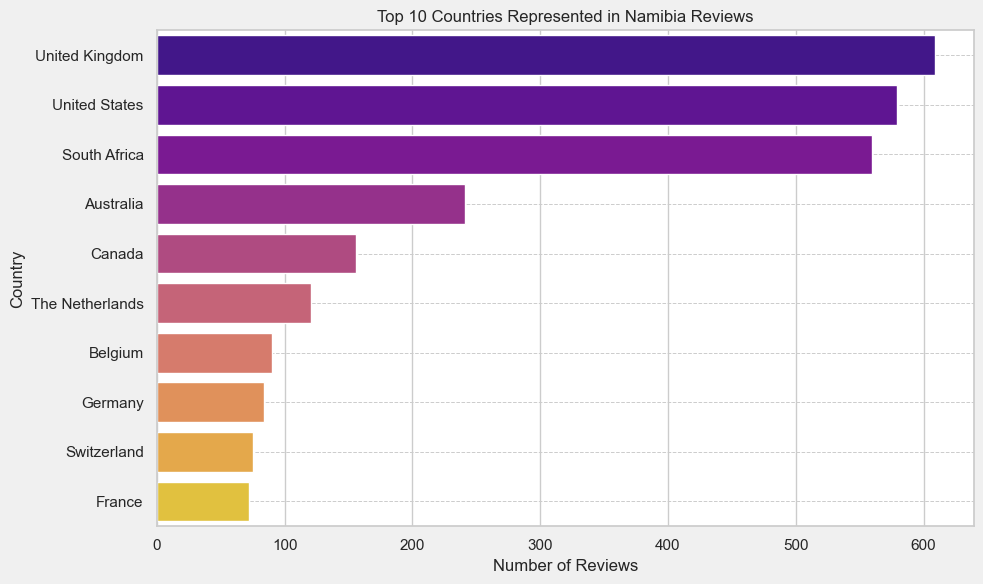

In [15]:
# Make sure country column is cleaned again
df['tourist_country'] = df['tourist_country'].str.split(',').str[-1].str.strip()
df['tourist_country'] = df['tourist_country'].replace(country_mapping)

# Count the top 10 countries after cleaning
top_countries = df['tourist_country'].value_counts().nlargest(10).reset_index()
top_countries.columns = ['Country', 'ReviewCount']

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(data=top_countries, y='Country', x='ReviewCount', hue='Country', palette='plasma', dodge=False, legend=False)
plt.title('Top 10 Countries Represented in Namibia Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.grid(True, axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

We will simplify the graph by limiting the number of countries or using a different type of plot to reduce the memory load. Here's how we can limit the analysis to the top 5 countries and use a more manageable graph:

<Figure size 1000x600 with 0 Axes>

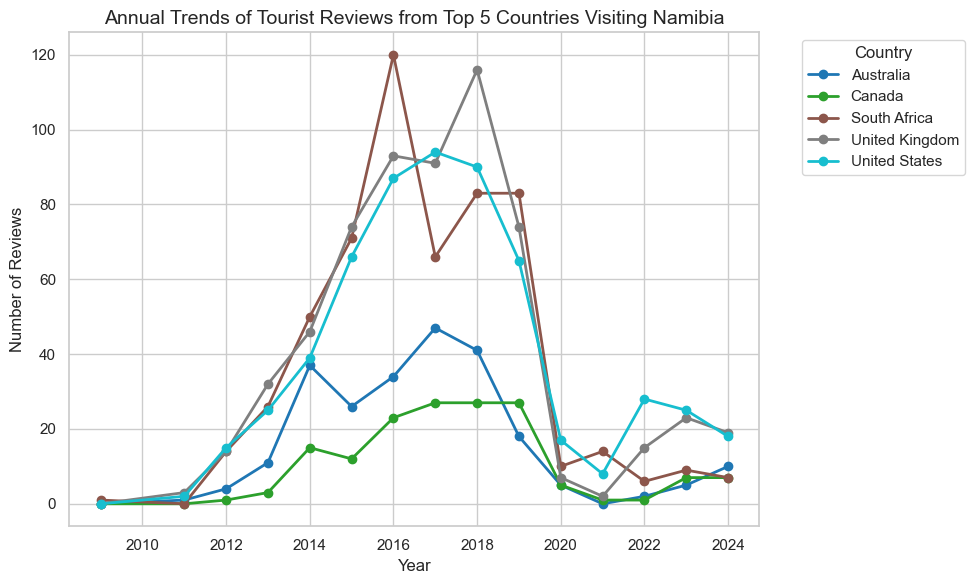

In [16]:
# Limit the number of countries to top 5 by reviews
top_countries = clean_df['tourist_country'].value_counts().index[:5]
df_filtered = clean_df[clean_df['tourist_country'].isin(top_countries)]

# Group by 'tourist_country' and 'Year' to get the review count for each year
df_country_year_filtered = df_filtered.groupby(['tourist_country', 'Year']).size().unstack().fillna(0)

# Create a line plot showing the country representation per year
plt.figure(figsize=(10, 6))
df_country_year_filtered.T.plot(kind='line', marker='o', figsize=(10,6), colormap='tab10', linewidth=2)

plt.title('Annual Trends of Tourist Reviews from Top 5 Countries Visiting Namibia', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(True)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### 4.3. Distribution of Reviews Over Time

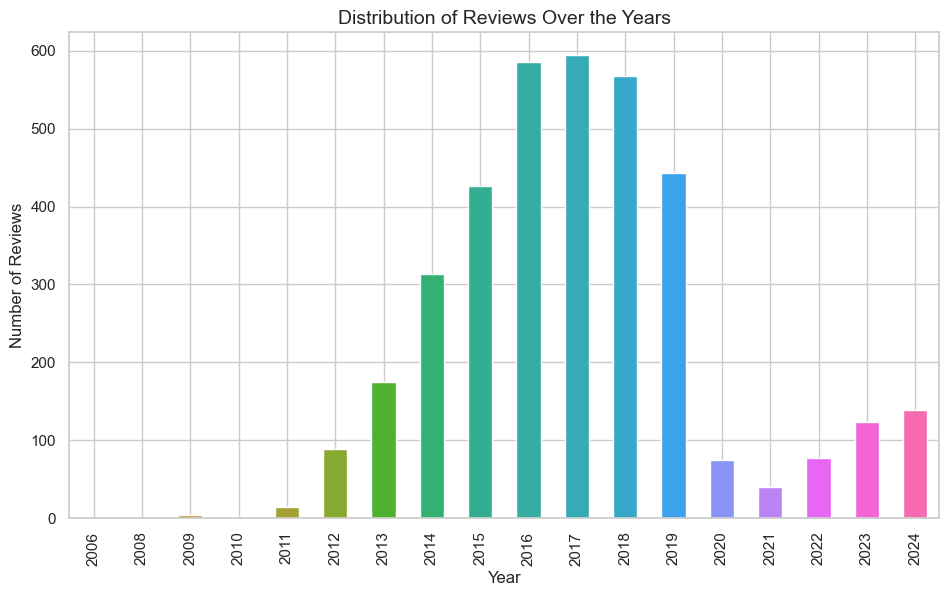

In [17]:
# Bar plot to show the distribution of reviews over the years with distinct colors for each year
plt.figure(figsize=(10, 6))

# Group by year and count the reviews per year
yearly_reviews = clean_df['Year'].value_counts().sort_index()

# Generate a bar plot with distinct colors
yearly_reviews.plot(kind='bar', color=sns.color_palette("husl", len(yearly_reviews)))

plt.title('Distribution of Reviews Over the Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(True, axis='y')

plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_visits_by_day_and_month(df):
    plt.figure(figsize=(16, 6))

    # Plot 1: Visits by Day of Week
    plt.subplot(1, 2, 1)
    sns.countplot(y='WeekDay', data=df, 
                  order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                  palette='coolwarm')
    plt.title('Visits by Day of Week')
    plt.xlabel('Number of Visits')
    plt.ylabel('Day')

    # Plot 2: Visits by Month
    plt.subplot(1, 2, 2)
    sns.countplot(y='Month', data=df,
                  order=['January', 'February', 'March', 'April', 'May', 'June',
                         'July', 'August', 'September', 'October', 'November', 'December'],
                  palette='husl')
    plt.title('Visits by Month')
    plt.xlabel('Number of Visits')
    plt.ylabel('Month')

    plt.tight_layout()
    plt.show()

C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\107794254.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='WeekDay', data=df,
C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\107794254.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Month', data=df,


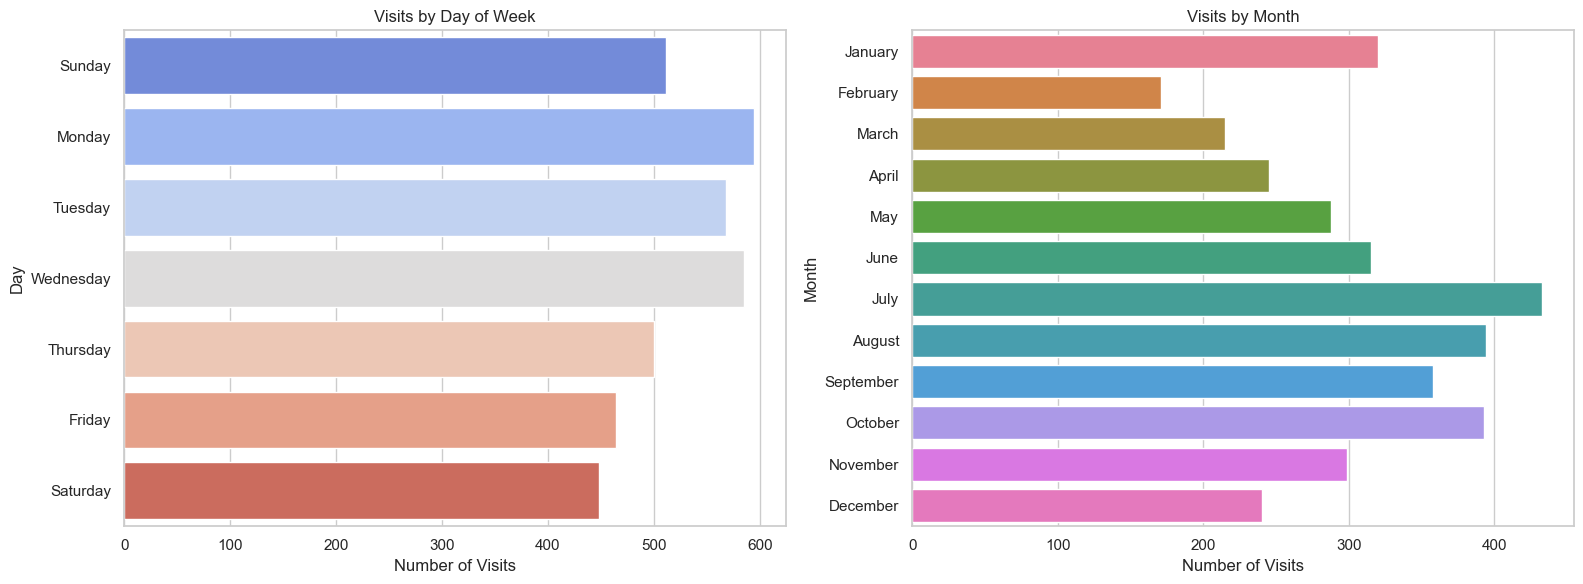

In [19]:
    plot_visits_by_day_and_month(clean_df)

#### Top 5 Reviewed Places

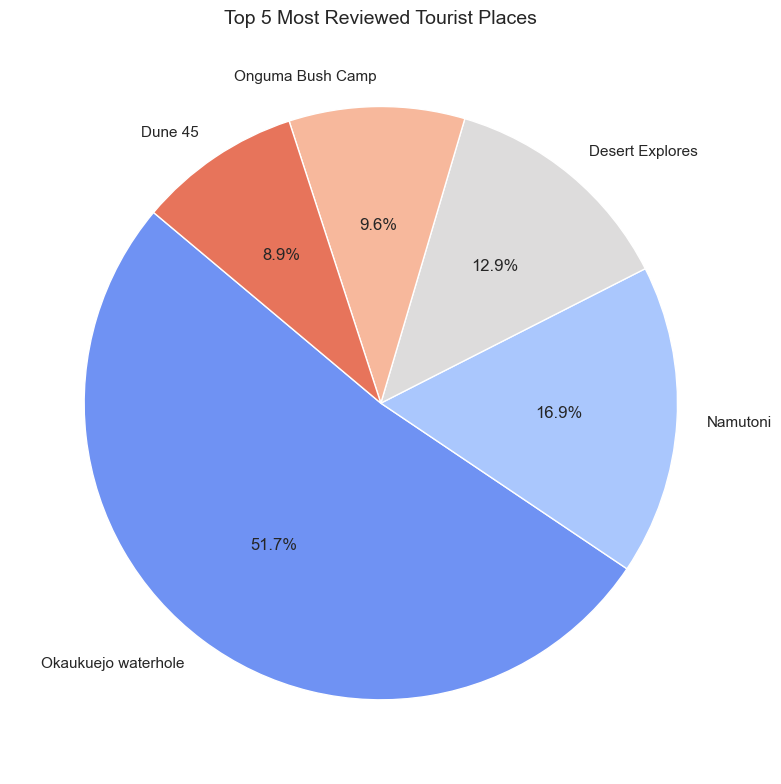

In [20]:
# Get top 5 reviewed places
top5_places = clean_df['reviewed_place'].value_counts().nlargest(5)

# Plot
plt.figure(figsize=(8, 8))
colors = sns.color_palette("coolwarm", len(top5_places))
top5_places.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

plt.title('Top 5 Most Reviewed Tourist Places', fontsize=14)
plt.ylabel('')  # Hides the y-label for cleaner look
plt.tight_layout()
plt.show()


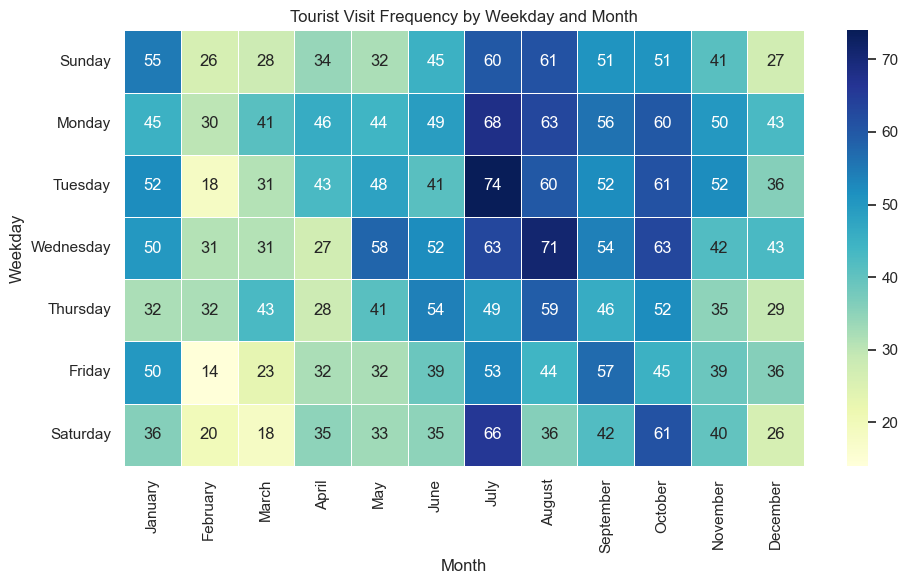

In [21]:
plt.figure(figsize=(10, 6))
weekdays_count = pd.crosstab(clean_df['WeekDay'], clean_df['Month'])
sns.heatmap(weekdays_count, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Tourist Visit Frequency by Weekday and Month')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()

##### 4.4. Tourist Types Distribution

In [23]:
# Clean 'tourist_type' values
df['tourist_type'] = df['tourist_type'].str.strip().str.lower().fillna('unknown')

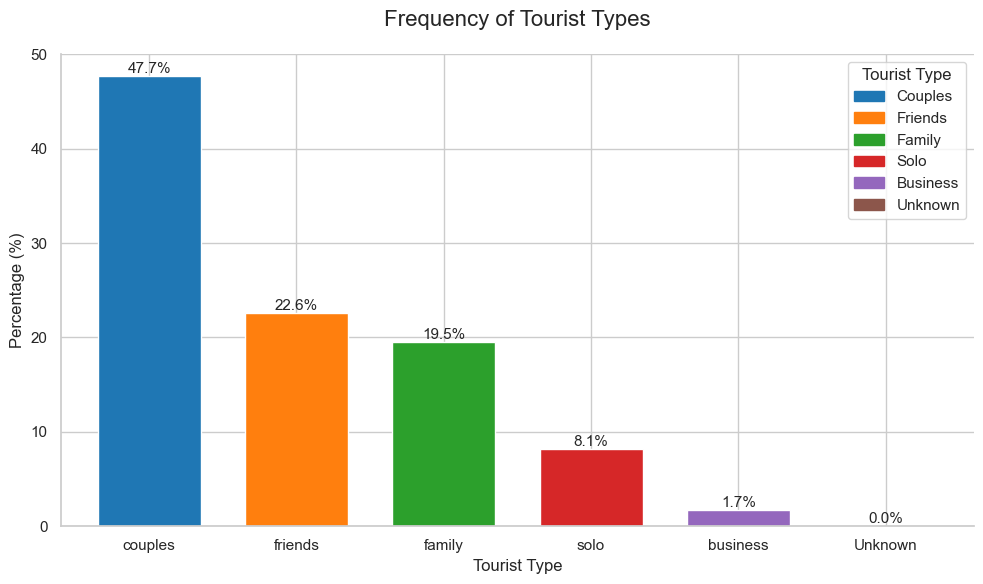

In [24]:
from matplotlib.patches import Patch  # <- Add this line

# Assume df is your DataFrame and already contains a 'tourist_type' column
df = pd.DataFrame(df)

# Calculate percentages
type_counts = df['tourist_type'].value_counts(normalize=True) * 100
type_counts = type_counts.reindex(['couples', 'friends', 'family', 'solo', 'business', 'Unknown']).fillna(0)

# Define colors and labels (including 'Unknown')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
labels = ['Couples', 'Friends', 'Family', 'Solo', 'Business', 'Unknown']

# Create plot
plt.figure(figsize=(10, 6))
ax = type_counts.plot(kind='bar', color=colors, width=0.7)

# Customize plot
plt.title('Frequency of Tourist Types', fontsize=16, pad=20)
plt.xlabel('Tourist Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points', fontsize=11)

# Add legend manually
legend_handles = [Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_handles, title="Tourist Type", loc='upper right')

# Final touches
sns.despine()
plt.tight_layout()
plt.show()


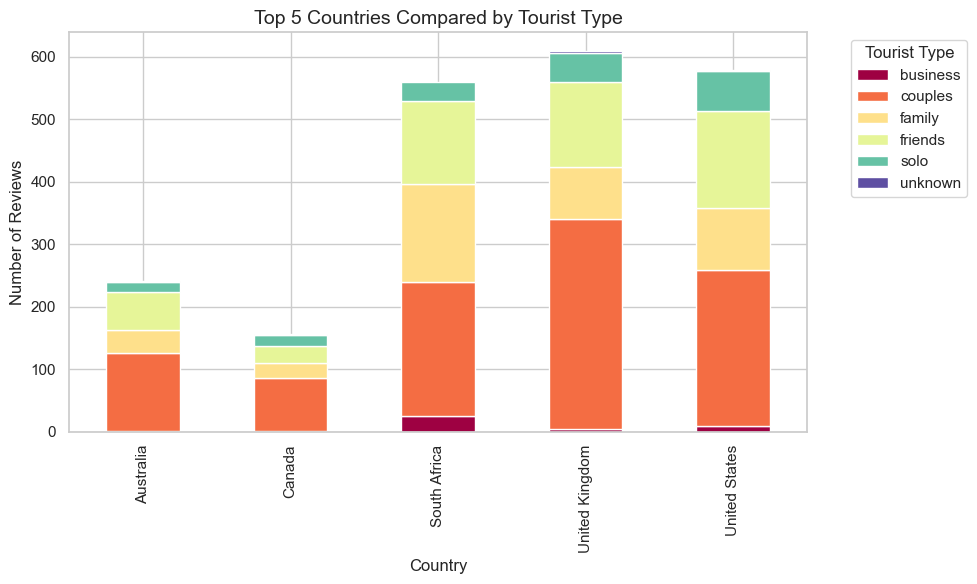

In [25]:
# Filter to top 5 countries
top_countries = clean_df['tourist_country'].value_counts().index[:5]
df_filtered = clean_df[clean_df['tourist_country'].isin(top_countries)]

# Group by country and tourist type
country_type = df_filtered.groupby(['tourist_country', 'tourist_type']).size().unstack().fillna(0)

# Stacked bar chart
country_type.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Spectral')
plt.title('Top 5 Countries Compared by Tourist Type', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(True)
plt.legend(title='Tourist Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

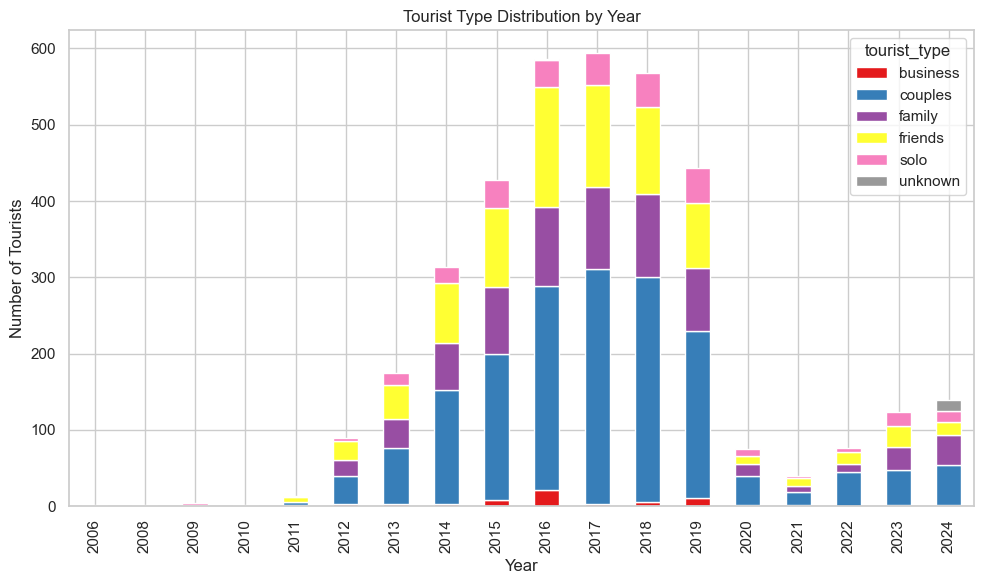

In [26]:
plt.figure(figsize=(10, 6))
tourist_type_by_year = pd.crosstab(clean_df['Year'], clean_df['tourist_type'])
tourist_type_by_year.plot(kind='bar', stacked=True, colormap='Set1', figsize=(10, 6))
plt.title('Tourist Type Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Tourists')
plt.tight_layout()
plt.show()

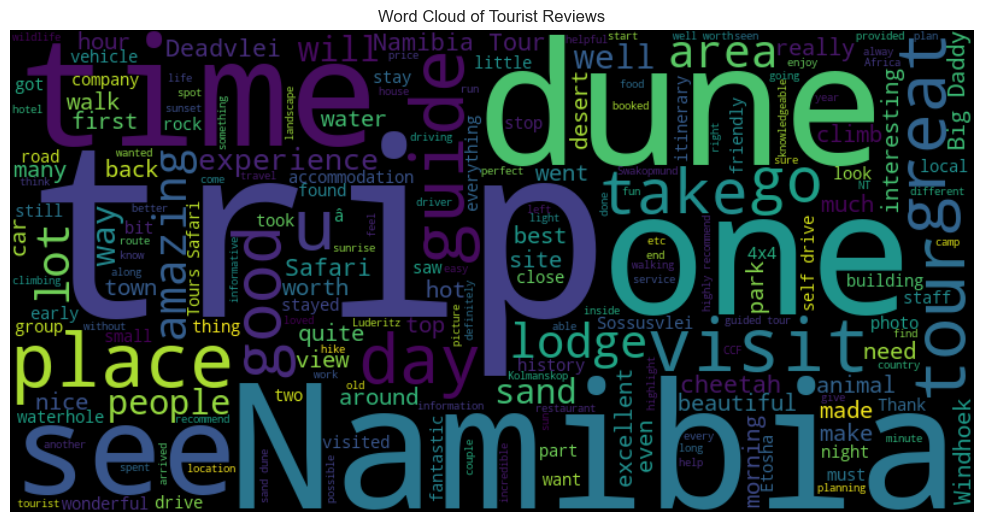

In [27]:
# Concatenate all reviews into one string for the word cloud
from wordcloud import WordCloud
text = " ".join(review for review in clean_df['reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Tourist Reviews')
plt.tight_layout()
plt.show()

In [28]:
print(df.columns)

Index(['Id', 'tourist_country', 'topic', 'reviews', 'visit_date',
       'review_date', 'tourist_type', 'reviewed_place', 'WeekDay', 'Month',
       'Year', 'PreprocessedReviews', 'CleanedReviews'],
      dtype='object')


In [29]:
clean_df.describe()

Id                     visit_date  \
count  3671.000000                           3671   
mean   1836.000000  2017-08-07 16:22:13.696540672   
min       1.000000            2006-06-06 00:00:00   
25%     918.500000            2015-10-26 12:00:00   
50%    1836.000000            2017-05-23 00:00:00   
75%    2753.500000            2018-12-15 12:00:00   
max    3671.000000            2024-12-18 00:00:00   
std    1059.870747                            NaN   

                         review_date         Year  
count                           3671       3671.0  
mean   2017-08-07 16:22:13.696540672  2017.074639  
min              2006-06-06 00:00:00       2006.0  
25%              2015-10-26 12:00:00       2015.0  
50%              2017-05-23 00:00:00       2017.0  
75%              2018-12-15 12:00:00       2018.0  
max              2024-12-18 00:00:00       2024.0  
std                              NaN     2.761232

# Model Training and Evaluation

##### 4.1. Get Polarity Scores using Vader

#### Sentiment Distribution

In [76]:
#Merge the polarity scores data frame with the main data frame
clean_df = pd.DataFrame(res).T
clean_df = clean_df.reset_index().rename(columns={'index': 'Id'})
clean_df = clean_df.merge(df, how='left')

#Compute Negative Neutral and Positive
def GetAnalysis(score):
    if score <0:
        return "Negative"
    elif score==0:
        return "Neutral"
    else:
        return "Positive"
clean_df['VaderAnalysis']=clean_df['compound'].apply(GetAnalysis)
clean_df['VaderAnalysis'].head()

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: VaderAnalysis, dtype: object

In [77]:
#percentage of positive Reviews 
positiveReviews=clean_df[clean_df.VaderAnalysis=='Positive']
print(round((positiveReviews.shape[0]/clean_df.shape[0])*100,1))

89.3


In [78]:
#percentage of Negative Reviews 
positiveReviews=clean_df[clean_df.VaderAnalysis=='Negative']
print(round((positiveReviews.shape[0]/clean_df.shape[0])*100,1))

8.7


In [79]:
#percentage of Neutral Reviews 
positiveReviews=clean_df[clean_df.VaderAnalysis=='Neutral']
print(round((positiveReviews.shape[0]/clean_df.shape[0])*100,1))

1.9


C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\4280336931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=clean_df, x='VaderAnalysis', palette='Set2')


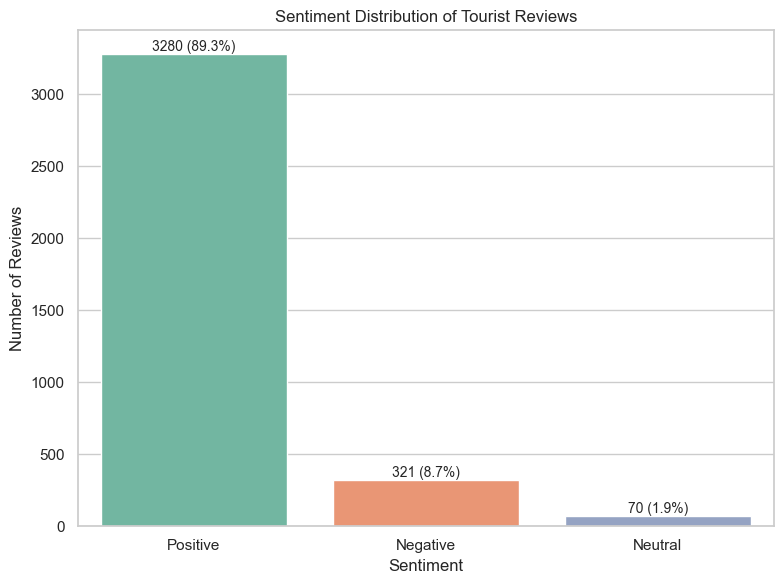

In [81]:
# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=clean_df, x='VaderAnalysis', palette='Set2')

# Calculate total number of reviews
total = len(clean_df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Final touches
plt.title('Sentiment Distribution of Tourist Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()


In [84]:
#print positive Reviews
j=1
sortedDF=clean_df.sort_values(by=["compound"])
for i in range(0,sortedDF.shape[0]):
    if (sortedDF['VaderAnalysis'][i]=='Positive'):
        print(str(j)+'.'+sortedDF['PreprocessedReviews'][i])
        print()
        j=j+1

1.We booked a visit to Kolmanskop. You can only visit the ghost town with a guide. Eveything was perfectly organized. First you make a tour with a guide in an international group. After that there is plenty of time to explore the place on your own. Visits 10-13h. Make sure you are on time at the gate. The guides are very passionate and make the town alive again with their stories.

2.We had a great time. The organisation of the whole 8 days (three locations) was faultless. What a staggeringly magnificent place Namibia is. It's grandeur is only matched by the hospitality of it's people. Very many thanks to Namibia Tours and Safaris for making sure things ran to plan

3.Deadvlei is definitely a highlight of Sossusvlei.  The contrasting colours are spectacular.To reach Deadvlei one needs a 4x4 vehicle to drive the last 5km's to the Deadvlei parking area.  If you don't have a 4x4, NWR offers a 4x4 return taxi service to the Deadvlei parking area for R150pp.  From the parking area, one has 

In [85]:
#print Negative Reviews
j=1
sortedDF=clean_df.sort_values(by=["compound"])
for i in range(0,sortedDF.shape[0]):
    if (sortedDF['VaderAnalysis'][i]=='Negative'):
        print(str(j)+'.'+sortedDF['PreprocessedReviews'][i])
        print()
        j=j+1

1.We went at mid-day because it was a long drive to get there. We were the only couple in Dead Vlei so it was really quiet and interesting. However, the heat was too much and my wife felt very ill on the 30 minute walk back to the truck. The transport in/out for the final 4Km for those without 4wheel drive was very efficient. If you go when it is cooler I guess it will be busier!

2.What sets this place apart from any other ghost town I have visited is both the use of extremely solid architecture & the fact that it is slowly fading away into the sand. We arrived when the gates opened at 8:00am and had the place to ourselves for over an hour before everyone started driving in for the first tour at 9:30am. You can literally walk/crawl through all the buildings. Each room looks different with the amount of sand and the amount of light. I wouldn't say it is spooky, but post apocalyptic would probably be fitting. The tours they offer are really good and very insightful. Absolutely worth the

In [86]:
#print Neutral Reviews
j=1
sortedDF=clean_df.sort_values(by=["compound"])
for i in range(0,sortedDF.shape[0]):
    if (sortedDF['VaderAnalysis'][i]=='Neutral'):
        print(str(j)+'.'+sortedDF['PreprocessedReviews'][i])
        print()
        j=j+1

1.There is plenty of rock art to see and Feb is v. hot, wear a hat and comfy shoes for a little climbing..

2.we came from the ocean, after we've seen hours of flat plains, we saw this mountain from a large distance. So orange!

3.Going to Deadvlei you choose to climb this dune or watch it from the distance. Either way this location is a must see spot, if you are in the neighboorhood.Magnificent nature experience.

4.UNESCO world heritage site. The rocks are covered in thousands of paintings and ancient engravings of animals.Most famous is The Lion Man. Guided tours.

5.Quite a climb so take lots of water and go at your own pace - you'll see Big Mamma from the summit and can descend fairly quickly down to Deadvlei

6.The tour of Namibia and surroundings was just great.As expected there were plenty of animals, some moving, some not.The vehicle got us from A to B which was what we wanted.

7.People sit here for hours and hours to, see what happens at the waterhole. There is a shady part 

In [92]:
# Test Sentiment Example
example='It would be such a shame to go to Namibia and not visit Sossusvlei and in particulat Big Daddy and deadvlei,no where else would you be able to see and photograph dunes and the sky with these colors....beautiful!'
sia.polarity_scores(example)

{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'compound': -0.5255}

In [99]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [100]:
#Pretrained model by huggingface
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" #PretrainedModel
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [101]:
#Run example on roberta
example='It would be such a shame to go to Namibia and not visit Sossusvlei and in particulat Big Daddy and deadvlei,no where else would you be able to see and photograph dunes and the sky with these colors....beautiful!'
text_encoded=tokenizer(example,return_tensors='pt') #Eencodes the text into 1s and 0s for the model to understand
output = model(**text_encoded)
scores = output[0][0].detach().numpy()#Roberta gives scores as tensors. this changes it to numpy. 
scores = softmax(scores) #Apply softmax to give the values between 0 and 1
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.1717764, 'roberta_neu': 0.2928284, 'roberta_pos': 0.53539515}


In [102]:
# RoBERTa polarity scoring function
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    probs = softmax(scores)
    return {
        'roberta_neg': probs[0],
        'roberta_neu': probs[1],
        'roberta_pos': probs[2]
    }

# Loop through the dataset and calculate sentiment scores
res = {}

for i, row in tqdm(clean_df.iterrows(), total=len(clean_df)):
    try:
        text = row['PreprocessedReviews']
        myid = row['Id']
        
        # Get VADER scores
        vader_results = sia.polarity_scores(text)
        vader_scores = {f"vader_{k}": v for k, v in vader_results.items()}

        # Get RoBERTa scores
        roberta_scores = polarity_scores_roberta(text)

        # Combine results
        combined = {**vader_scores, **roberta_scores}
        res[myid] = combined

    except RuntimeError as e:
        print(f"RuntimeError at id{row['Id']}: {e}")
    except Exception as e:
        print(f"Failed for id{row['Id']}: {e}")

# Convert to DataFrame and merge
results_df = pd.DataFrame.from_dict(res, orient='index').reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(clean_df, on='Id', how='left')

# Drop old VADER columns if they exist in clean_df
for col in ['neg', 'pos', 'neu', 'compound']:
    if col in results_df.columns:
        results_df = results_df.drop(columns=col)

100%|██████████████████████████████████████████████████████████████████████████████| 3671/3671 [17:46<00:00,  3.44it/s]


In [103]:
results_df.head()

Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0   1      0.028      0.814      0.158          0.8883     0.003205   
1   2      0.000      0.684      0.316          0.9632     0.002412   
2   3      0.000      0.885      0.115          0.8555     0.015848   
3   4      0.000      0.679      0.321          0.9149     0.009038   
4   5      0.000      0.723      0.277          0.9052     0.001152   

   roberta_neu  roberta_pos tourist_country  \
0     0.087664     0.909131         Belgium   
1     0.009756     0.987832  United Kingdom   
2     0.291542     0.692610    South Africa   
3     0.073470     0.917492       Australia   
4     0.010456     0.988391           Spain   

                                               topic  ... visit_date  \
0   Ghost town Kolmanskop 10 km drive from LÃ¼deritz  ... 2019-08-23   
1  Great experience. Perfect planning and organis...  ... 2022-12-15   
2                                       Just Amazing  ... 2017-05-29   
3                                          Very good  ... 2014-05-21   
4                                  Travel to Namibia  ... 2016-10-14   

  review_date tourist_type               reviewed_place    WeekDay     Month  \
0  2019-08-23      friends                  Epupa Falls     Friday    August   
1  2022-12-15      friends          Okaukuejo waterhole   Thursday  December   
2  2017-05-29      friends  Daan Viljoen Nature Reserve     Monday       May   
3  2014-05-21      couples                     Namutoni  Wednesday       May   
4  2016-10-14      couples          Okaukuejo waterhole     Friday   October   

   Year                                PreprocessedReviews  \
0  2019  We booked a visit to Kolmanskop. You can only ...   
1  2022  We had a great time. The organisation of the w...   
2  2017  Deadvlei is definitely a highlight of Sossusvl...   
3  2014  Wonderful place to wander around and try to im...   
4  2016  Namibia Tours & Safaris organized very well ou...   

                                      CleanedReviews VaderAnalysis  
0  booked visit kolmanskop visit ghost town guide...      Positive  
1  great time organisation days locations faultle...      Positive  
2  deadvlei definitely highlight sossusvlei contr...      Positive  
3  wonderful place wander try imagine like live t...      Positive  
4  namibia tours safaris organized travel namibia...      Positive  

[5 rows x 21 columns]

In [104]:
#Use lambda function to label tweet as positive, negative or neutral
results_df['Rob_Analysis'] = results_df.apply(lambda x:'Negative' if x['roberta_neg'] >
                     x['roberta_neu'] and x['roberta_neu']
                     > x['roberta_pos'] else ('Neutral' if x['roberta_neu']>x['roberta_pos'] else 'Positive'),axis=1)
results_df['Rob_Analysis'].head()

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: Rob_Analysis, dtype: object

In [105]:
#percentage of positive Reviews 
positiveReviews=results_df[results_df.Rob_Analysis=='Positive']
print(round((positiveReviews.shape[0]/results_df.shape[0])*100,1))

86.6


In [106]:
#percentage of Negative Reviews 
positiveReviews=results_df[results_df.Rob_Analysis=='Negative']
print(round((positiveReviews.shape[0]/results_df.shape[0])*100,1))

5.4


In [107]:
#percentage of Neutral Reviews 
positiveReviews=results_df[results_df.Rob_Analysis=='Neutral']
print(round((positiveReviews.shape[0]/results_df.shape[0])*100,1))

7.9


In [ ]:
TBC

C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\499608268.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(y="VaderAnalysis", data=results_df, palette=vader_palette)
C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\499608268.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(y="Rob_Analysis", data=results_df, palette=roberta_palette)


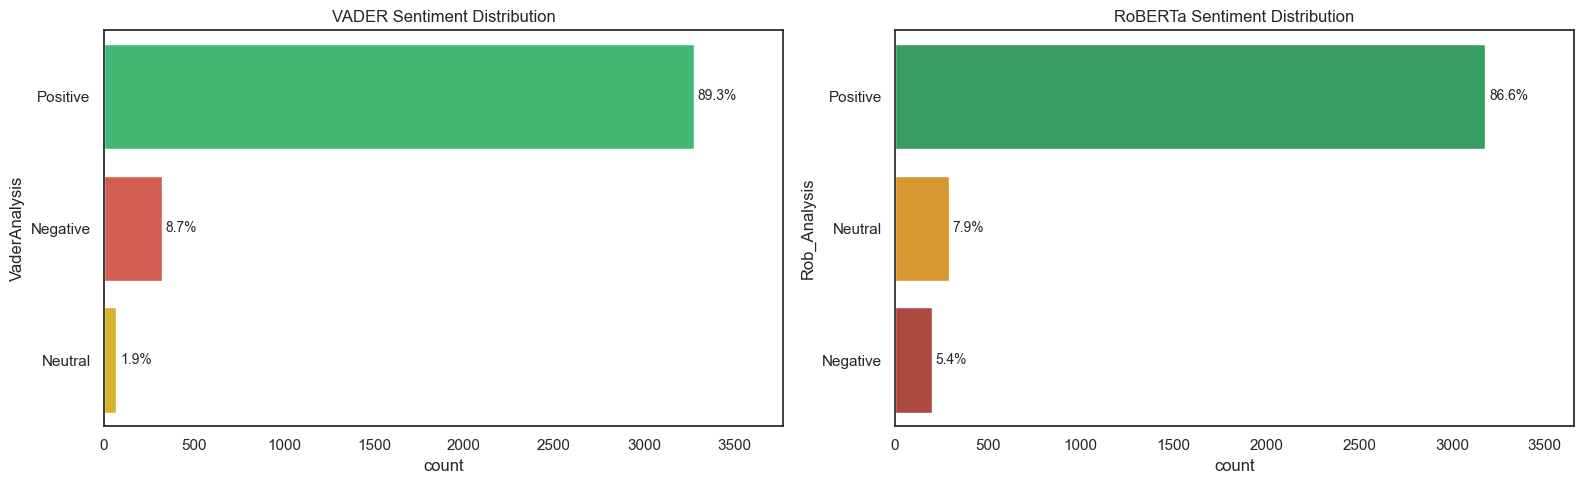

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color codes for sentiment labels
vader_palette = {"Positive": "#2ecc71", "Negative": "#e74c3c", "Neutral": "#f1c40f"}
roberta_palette = {"Positive": "#27ae60", "Negative": "#c0392b", "Neutral": "#f39c12"}

# Set up larger figure size and style
plt.figure(figsize=(16, 5))
sns.set(style="white")

# Plot for VADER
plt.subplot(1, 2, 1)
ax1 = sns.countplot(y="VaderAnalysis", data=results_df, palette=vader_palette)
plt.title("VADER Sentiment Distribution")

# Add percentage labels to VADER
vader_total = len(results_df["VaderAnalysis"])
max_count_vader = max([p.get_width() for p in ax1.patches])
for p in ax1.patches:
    count = p.get_width()
    percentage = 100 * count / vader_total
    ax1.text(count + 20, p.get_y() + p.get_height() / 2, f'{percentage:.1f}%', va='center', fontsize=10)
ax1.set_xlim(0, max_count_vader * 1.15)

# Plot for RoBERTa
plt.subplot(1, 2, 2)
ax2 = sns.countplot(y="Rob_Analysis", data=results_df, palette=roberta_palette)
plt.title("RoBERTa Sentiment Distribution")

# Add percentage labels to RoBERTa
roberta_total = len(results_df["Rob_Analysis"])
max_count_roberta = max([p.get_width() for p in ax2.patches])
for p in ax2.patches:
    count = p.get_width()
    percentage = 100 * count / roberta_total
    ax2.text(count + 20, p.get_y() + p.get_height() / 2, f'{percentage:.1f}%', va='center', fontsize=10)
ax2.set_xlim(0, max_count_roberta * 1.15)

plt.tight_layout()
plt.show()

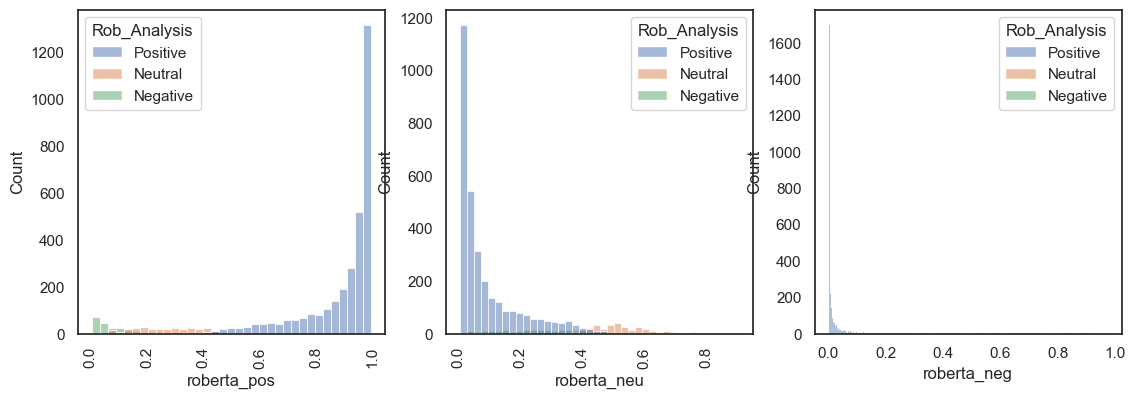

In [112]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import torch.nn.functional as F

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# Define sentiment labels (same as in the model config)
labels = ['Negative', 'Neutral', 'Positive']

# Sample and drop NaNs
sample = clean_df['PreprocessedReviews'].dropna().sample(200, random_state=42).tolist()

results = []

# Inference loop
for review in sample:
    # Tokenize with truncation
    inputs = tokenizer(
        review,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
        scores = F.softmax(outputs.logits, dim=1)
        predicted_label = torch.argmax(scores).item()
        confidence = scores[0][predicted_label].item()

    results.append({
        "Review": review,
        "RoBERTa_Label": labels[predicted_label],
        "RoBERTa_Score": confidence
    })

# Convert to DataFrame
roberta_df = pd.DataFrame(results)

# Display first few rows
roberta_df.head()


Review RoBERTa_Label  \
0  Namibia Tours organised a very well-planned 23...      Positive   
1  This rather underwhelming church serves as a c...      Negative   
2  You can arrange a tour from Luderitz or self d...      Positive   
3  What a fabulous trip.  I completed a 45 day se...      Positive   
4  this was a low.............yes, the drought ha...      Negative   

   RoBERTa_Score  
0       0.987885  
1       0.871699  
2       0.942504  
3       0.609824  
4       0.946659

In [82]:
print(clean_df.columns)

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'tourist_country', 'topic',
       'reviews', 'visit_date', 'review_date', 'tourist_type',
       'reviewed_place', 'WeekDay', 'Month', 'Year', 'PreprocessedReviews',
       'CleanedReviews', 'VaderAnalysis'],
      dtype='object')


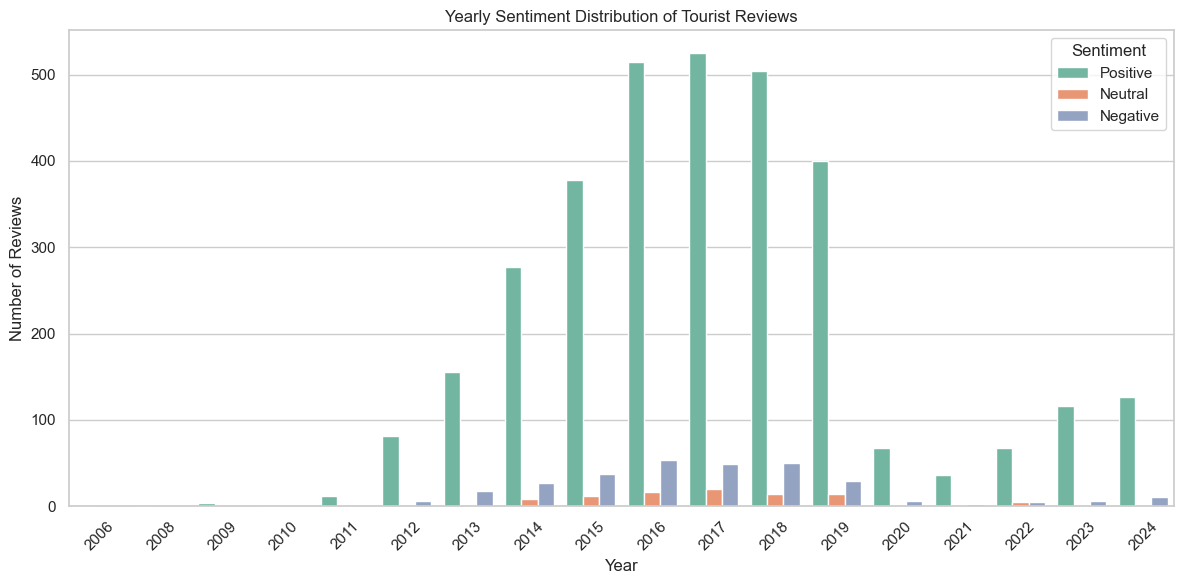

In [35]:
# Group by Year and Sentiment Label
sentiment_by_year = clean_df.groupby(['Year', 'sentiment_label']).size().reset_index(name='count')

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_by_year, x='Year', y='count', hue='sentiment_label', palette='Set2')

# Customize plot
plt.title('Yearly Sentiment Distribution of Tourist Reviews')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [37]:
# Create summary table with counts and percentages
summary_table = sentiment_pivot[[col for col in sentiment_pivot.columns if not col.endswith('_pct')]]

for sentiment in ['Positive', 'Neutral', 'Negative']:
    summary_table[sentiment + '_pct'] = sentiment_pivot[sentiment + '_pct'].astype(str) + '%'

# Reorder columns
summary_table = summary_table[[col for pair in zip(['Positive', 'Neutral', 'Negative'], 
                                                   ['Positive_pct', 'Neutral_pct', 'Negative_pct']) 
                               for col in pair]]

# Reset index to make 'Year' a column
summary_table = summary_table.reset_index()

# Rename columns
summary_table.columns = ['Year', 'Positive Count', 'Positive %', 
                         'Neutral Count', 'Neutral %', 
                         'Negative Count', 'Negative %']

# Display table
print("📊 Summary of Sentiment Distribution by Year:")
print(summary_table.to_string(index=False))


📊 Summary of Sentiment Distribution by Year:
 Year  Positive Count Positive %  Neutral Count Neutral %  Negative Count Negative %
 2006             1.0     100.0%            0.0      0.0%             0.0       0.0%
 2008             1.0     100.0%            0.0      0.0%             0.0       0.0%
 2009             4.0     100.0%            0.0      0.0%             0.0       0.0%
 2010             1.0     100.0%            0.0      0.0%             0.0       0.0%
 2011            12.0      85.7%            2.0     14.3%             0.0       0.0%
 2012            81.0      91.0%            2.0      2.2%             6.0       6.7%
 2013           155.0      88.6%            2.0      1.1%            18.0      10.3%
 2014           277.0      88.5%            9.0      2.9%            27.0       8.6%
 2015           378.0      88.5%           12.0      2.8%            37.0       8.7%
 2016           515.0      87.9%           17.0      2.9%            54.0       9.2%
 2017           525.

C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\1601936752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table[sentiment + '_pct'] = sentiment_pivot[sentiment + '_pct'].astype(str) + '%'
C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\1601936752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table[sentiment + '_pct'] = sentiment_pivot[sentiment + '_pct'].astype(str) + '%'


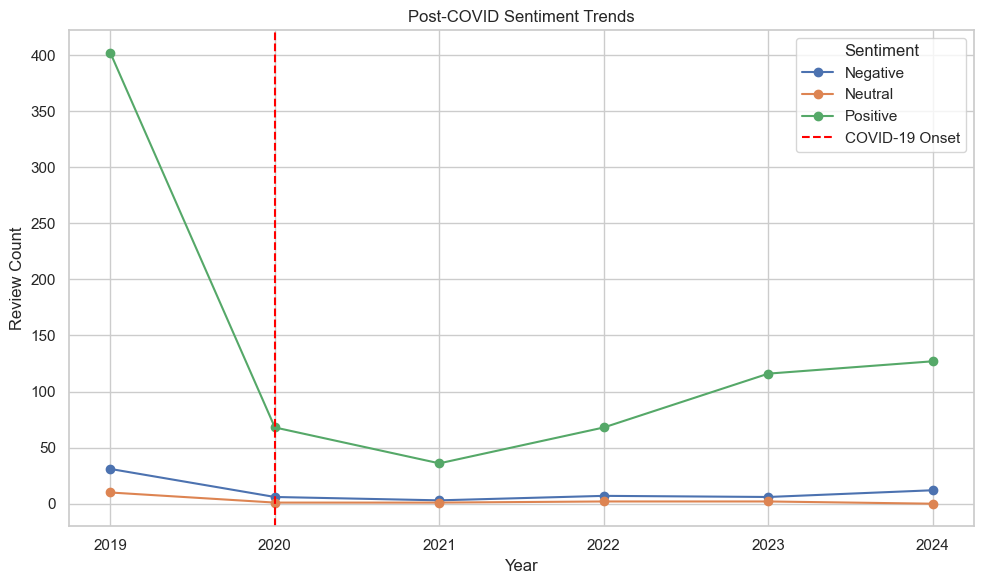

In [71]:
post_covid_df = clean_df[clean_df['Year'] >= 2019]
post_covid_sentiment = post_covid_df.groupby(['Year', 'VaderAnalysis']).size().unstack().fillna(0)

post_covid_sentiment.plot(figsize=(10, 6), marker='o')
plt.axvline(x=2020, color='red', linestyle='--', label='COVID-19 Onset')
plt.title('Post-COVID Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\2633647288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sent = clean_df.groupby(['Month', 'VaderAnalysis']).size().reset_index(name='count')


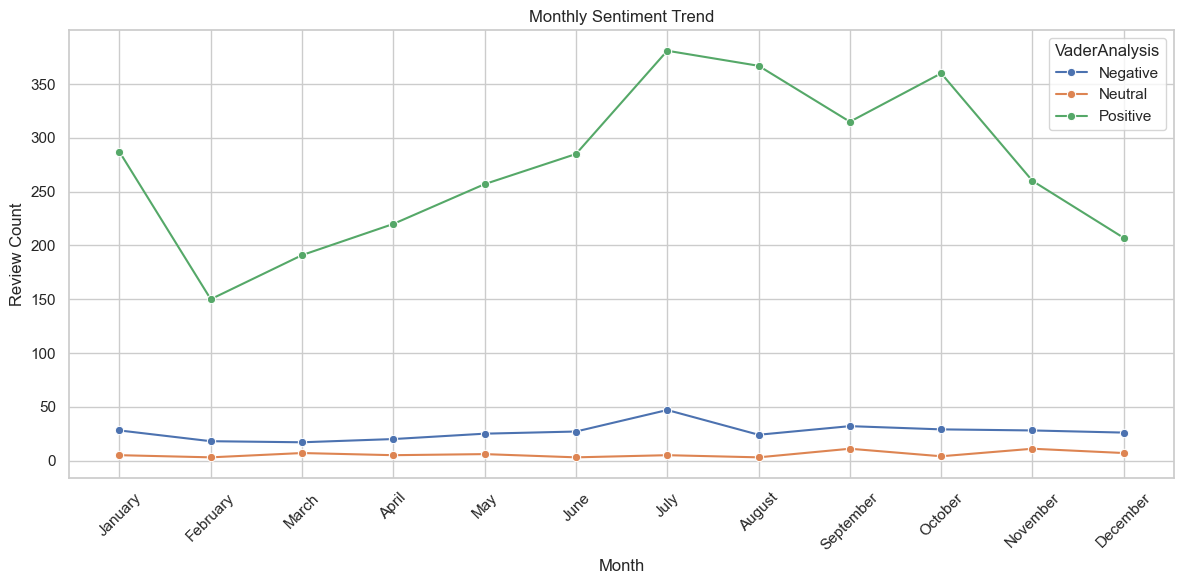

In [72]:
# 4. Monthly Sentiment Trends
monthly_sent = clean_df.groupby(['Month', 'VaderAnalysis']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sent, x='Month', y='count', hue='VaderAnalysis', marker='o')
plt.title('Monthly Sentiment Trend')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


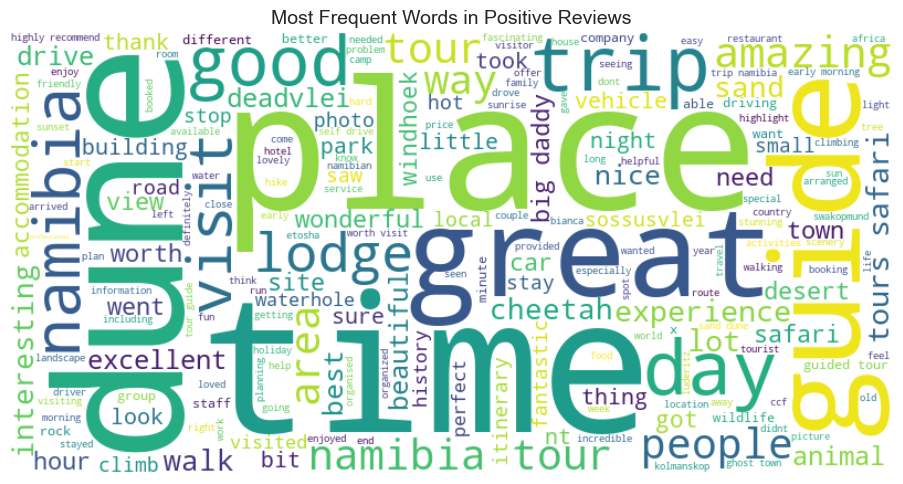

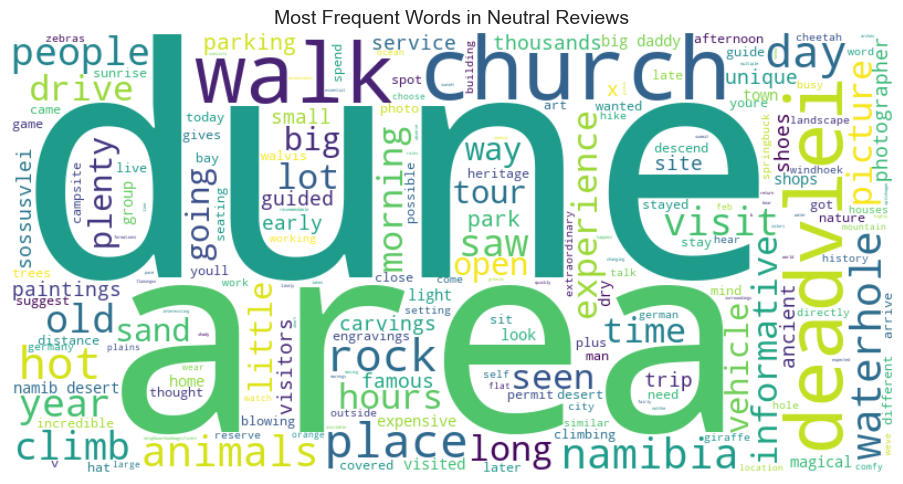

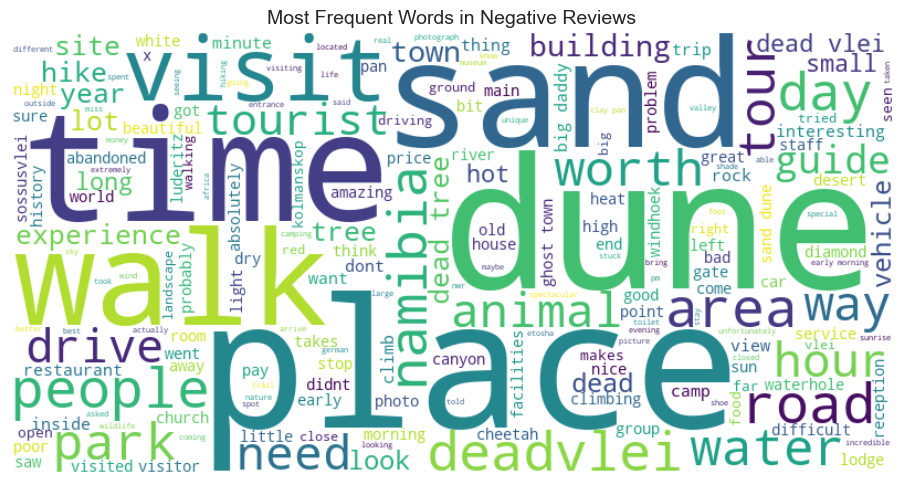

In [74]:
# 6. Word Frequency by Sentiment
def get_wordcloud(text, title, color='viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

for sentiment in ['Positive', 'Neutral', 'Negative']:
    filtered = clean_df[clean_df['VaderAnalysis'] == sentiment]['CleanedReviews']
    get_wordcloud(filtered, f'Most Frequent Words in {sentiment} Reviews')


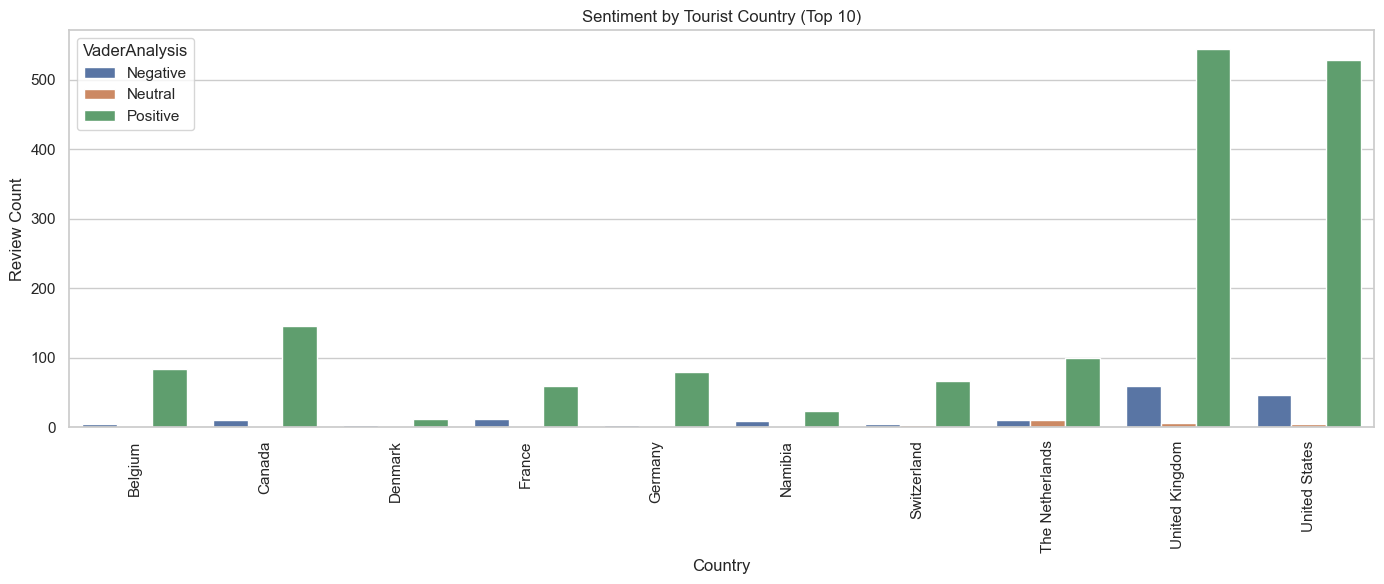

In [57]:
# 2. Sentiment by Tourist Country
sent_by_country = clean_df.groupby(['tourist_country', 'VaderAnalysis']).size().reset_index(name='count')
top_countries = sent_by_country['tourist_country'].value_counts().nlargest(10).index
sent_by_country_top = sent_by_country[sent_by_country['tourist_country'].isin(top_countries)]
plt.figure(figsize=(14, 6))
sns.barplot(data=sent_by_country_top, x='tourist_country', y='count', hue='VaderAnalysis')
plt.xticks(rotation=90)
plt.title('Sentiment by Tourist Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

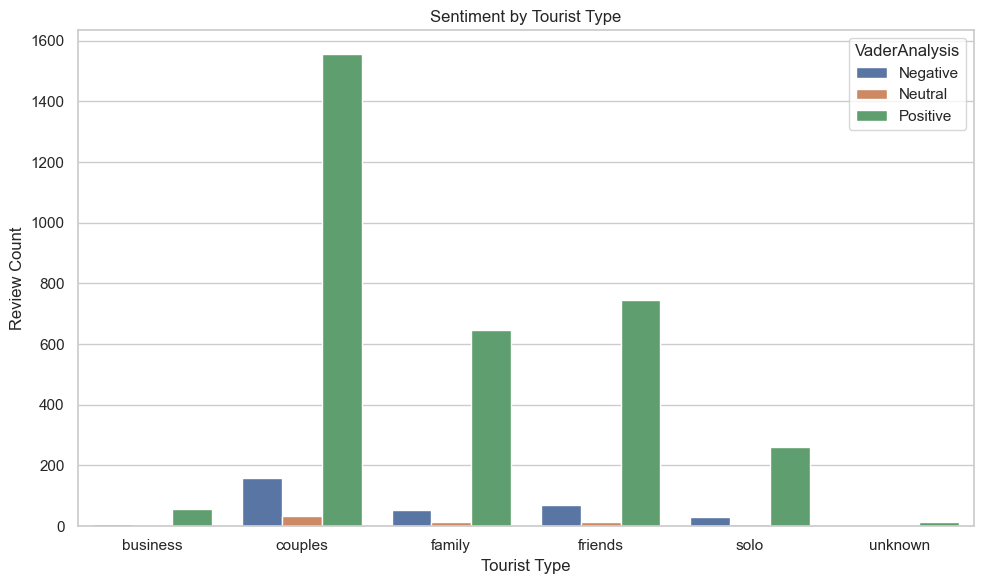

In [58]:
# 3. Sentiment by Tourist Type
sent_by_type = clean_df.groupby(['tourist_type', 'VaderAnalysis']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=sent_by_type, x='tourist_type', y='count', hue='VaderAnalysis')
plt.title('Sentiment by Tourist Type')
plt.xlabel('Tourist Type')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

In [39]:
# Get Polarity Scores
res = {}
for i, row in tqdm(df.iterrows(), total=len(clean_df)):
    text = row['PreprocessedReviews'] 
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)
pd.DataFrame(res).T #Turn vader results into a DataFrame

100%|█████████████████████████████████████████████████████████████████████████████| 3671/3671 [00:06<00:00, 528.18it/s]


neg    neu    pos  compound
1     0.028  0.814  0.158    0.8883
2     0.000  0.684  0.316    0.9632
3     0.000  0.885  0.115    0.8555
4     0.000  0.679  0.321    0.9149
5     0.000  0.723  0.277    0.9052
...     ...    ...    ...       ...
3667  0.076  0.805  0.119    0.6115
3668  0.027  0.973  0.000   -0.3400
3669  0.152  0.738  0.110   -0.2871
3670  0.051  0.931  0.018   -0.4123
3671  0.142  0.556  0.302    0.5574

[3671 rows x 4 columns]

In [40]:
pd.DataFrame(res).T.describe()

neg          neu          pos     compound
count  3671.000000  3671.000000  3671.000000  3671.000000
mean      0.031726     0.791172     0.177110     0.676222
std       0.042306     0.095213     0.097838     0.422521
min       0.000000     0.354000     0.000000    -0.990800
25%       0.000000     0.733000     0.110000     0.598350
50%       0.017000     0.801000     0.166000     0.859300
75%       0.051000     0.857000     0.235000     0.948700
max       0.367000     1.000000     0.621000     0.999900

In [41]:
from tqdm import tqdm
tqdm.pandas()

clean_df['vader_scores'] = clean_df['PreprocessedReviews'].progress_apply(sia.polarity_scores)
clean_df = pd.concat([clean_df.drop(['vader_scores'], axis=1), clean_df['vader_scores'].apply(pd.Series)], axis=1)
pd.DataFrame(res).T #Turn vader results into a DataFrame

pd.DataFrame(res).T.describe()

# Assuming `clean_df` contains the sentiment scores and `df` is the main data frame
# Merge the polarity scores with the main data frame
clean_df = pd.DataFrame(res).T  # Turn polarity results into a DataFrame
clean_df = clean_df.reset_index().rename(columns={'index': 'Id'})  # Ensure 'Id' column exists for merging
clean_df = df.merge(clean_df, how='left', left_on='Id', right_on='Id')  # Merge with the main df

# Compute Negative, Neutral, and Positive
def GetAnalysis(score):
    return 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')
    df['Sentiment'] = df['vader_scores'].apply(lambda x: get_sentiment_label(x['compound']))

clean_df['VaderAnalysis']=clean_df['compound'].apply(GetAnalysis)
clean_df['VaderAnalysis'].head()

#percentage of positive Reviews 
positiveReviews=clean_df[clean_df.VaderAnalysis=='Positive']
print(round((positiveReviews.shape[0]/clean_df.shape[0])*100,1))

#percentage of Negative Reviews 
NegativeReviews=clean_df[clean_df.VaderAnalysis=='Negative']
print(round((NegativeReviews.shape[0]/clean_df.shape[0])*100,1))

#percentage of Neutral Reviews 
NeutralReviews=clean_df[clean_df.VaderAnalysis=='Neutral']
print(round((NeutralReviews.shape[0]/clean_df.shape[0])*100,1))


100%|█████████████████████████████████████████████████████████████████████████████| 3671/3671 [00:06<00:00, 601.18it/s]


89.3
8.7
1.9


Data preparation

In [51]:
from sklearn.model_selection import train_test_split

X = clean_df['PreprocessedReviews']
y = clean_df['VaderAnalysis']  # Use this instead

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Text Vectorization

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Train Classical Models

Support Vector Machine (SVM)

In [132]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

LinearSVC()

Naive Bayes

In [133]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

Evaluate Models

In [134]:
from sklearn.metrics import classification_report

print("SVM Results:")
print(classification_report(y_test, svm.predict(X_test_tfidf)))

print("Naive Bayes Results:")
print(classification_report(y_test, nb.predict(X_test_tfidf)))


SVM Results:
              precision    recall  f1-score   support

    Negative       0.71      0.19      0.30        64
     Neutral       0.00      0.00      0.00        14
    Positive       0.91      0.99      0.95       657

    accuracy                           0.90       735
   macro avg       0.54      0.39      0.41       735
weighted avg       0.87      0.90      0.87       735

Naive Bayes Results:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        64
     Neutral       0.00      0.00      0.00        14
    Positive       0.89      1.00      0.94       657

    accuracy                           0.89       735
   macro avg       0.30      0.33      0.31       735
weighted avg       0.80      0.89      0.84       735



C:\Users\jshoo\anaconda3\envs\py310_snscrape\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jshoo\anaconda3\envs\py310_snscrape\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jshoo\anaconda3\envs\py310_snscrape\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [135]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification reports with zero_division=0 to suppress warnings
svm_report = classification_report(y_test, svm.predict(X_test_tfidf), output_dict=True, zero_division=0)
nb_report = classification_report(y_test, nb.predict(X_test_tfidf), output_dict=True, zero_division=0)

# Convert to DataFrames
svm_df = pd.DataFrame(svm_report).transpose()
nb_df = pd.DataFrame(nb_report).transpose()

# Round for readability
svm_df = svm_df.round(2)
nb_df = nb_df.round(2)

# Display the results
print("\nSVM Results:")
print(svm_df)

print("\nNaive Bayes Results:")
print(nb_df)



SVM Results:
              precision  recall  f1-score  support
Negative           0.71    0.19      0.30     64.0
Neutral            0.00    0.00      0.00     14.0
Positive           0.91    0.99      0.95    657.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.54    0.39      0.41    735.0
weighted avg       0.87    0.90      0.87    735.0

Naive Bayes Results:
              precision  recall  f1-score  support
Negative           0.00    0.00      0.00    64.00
Neutral            0.00    0.00      0.00    14.00
Positive           0.89    1.00      0.94   657.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.30    0.33      0.31   735.00
weighted avg       0.80    0.89      0.84   735.00


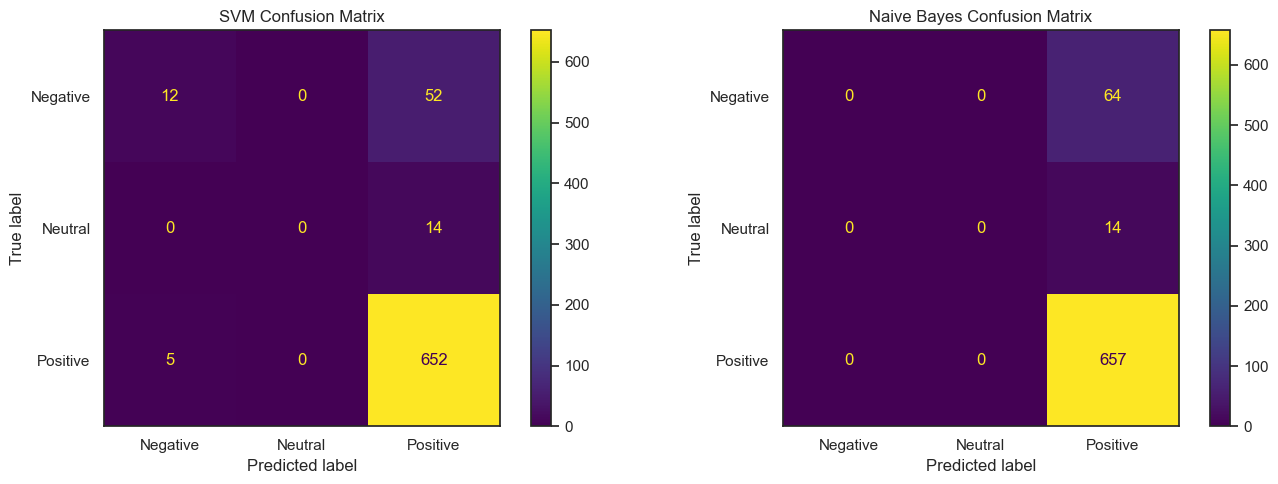

Model  precision_Negative  recall_Negative  f1-score_Negative  \
0          SVM            0.705882           0.1875           0.296296   
1  Naive Bayes            0.000000           0.0000           0.000000   

   precision_Neutral  recall_Neutral  f1-score_Neutral  precision_Positive  \
0                0.0             0.0               0.0            0.908078   
1                0.0             0.0               0.0            0.893878   

   recall_Positive  f1-score_Positive  
0          0.99239           0.948364  
1          1.00000           0.943966

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get unique labels from y_test and predictions
unique_labels = sorted(set(y_test) | set(svm.predict(X_test_tfidf)) | set(nb.predict(X_test_tfidf)))

# Generate classification reports
svm_report = classification_report(y_test, svm.predict(X_test_tfidf), output_dict=True, zero_division=0)
nb_report = classification_report(y_test, nb.predict(X_test_tfidf), output_dict=True, zero_division=0)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, svm.predict(X_test_tfidf), labels=unique_labels, ax=axes[0]
)
axes[0].set_title("SVM Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(
    y_test, nb.predict(X_test_tfidf), labels=unique_labels, ax=axes[1]
)
axes[1].set_title("Naive Bayes Confusion Matrix")

plt.tight_layout()
plt.show()

# Prepare the performance table dynamically
metrics = ['precision', 'recall', 'f1-score']
rows = []

for model_name, report in [('SVM', svm_report), ('Naive Bayes', nb_report)]:
    row = {'Model': model_name}
    for label in unique_labels:
        for metric in metrics:
            key = f'{metric}_{label.capitalize()}'
            row[key] = report.get(label, {}).get(metric, 0.0)
    rows.append(row)

# Create DataFrame
models_summary = pd.DataFrame(rows)

# Display the summary table
models_summary


In [138]:
from sklearn.metrics import confusion_matrix

# Predict the labels
svm_preds = svm.predict(X_test_tfidf)
nb_preds = nb.predict(X_test_tfidf)

# Generate confusion matrices
svm_cm = confusion_matrix(y_test, svm_preds, labels=svm.classes_)
nb_cm = confusion_matrix(y_test, nb_preds, labels=nb.classes_)

# Convert confusion matrices to DataFrames for better readability
svm_cm_df = pd.DataFrame(svm_cm, index=svm.classes_, columns=svm.classes_)
nb_cm_df = pd.DataFrame(nb_cm, index=nb.classes_, columns=nb.classes_)

print("\nSVM Confusion Matrix:")
print(svm_cm_df)

print("\nNaive Bayes Confusion Matrix:")
print(nb_cm_df)



SVM Confusion Matrix:
          Negative  Neutral  Positive
Negative        12        0        52
Neutral          0        0        14
Positive         5        0       652

Naive Bayes Confusion Matrix:
          Negative  Neutral  Positive
Negative         0        0        64
Neutral          0        0        14
Positive         0        0       657


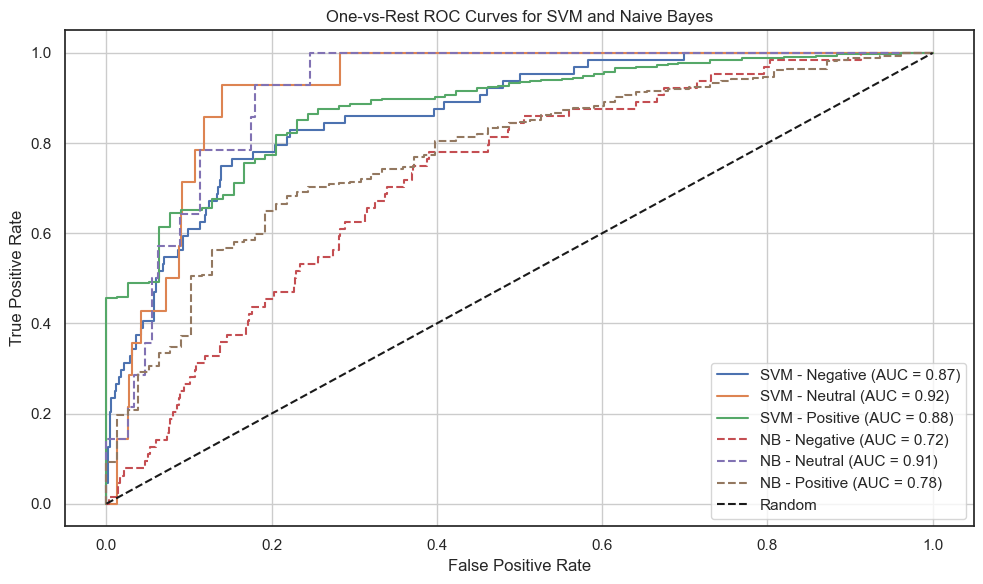

In [139]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression  # Just an example
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Binarize the labels
classes = ['Negative', 'Neutral', 'Positive']
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_train_bin.shape[1]

# Prepare TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Create one-vs-rest classifiers
svm_ovr = OneVsRestClassifier(SVC(probability=True, kernel='linear', random_state=42))
nb_ovr = OneVsRestClassifier(MultinomialNB())

# Train models
svm_ovr.fit(X_train_tfidf, y_train_bin)
nb_ovr.fit(X_train_tfidf, y_train_bin)

# Predict probabilities
svm_probs = svm_ovr.predict_proba(X_test_tfidf)
nb_probs = nb_ovr.predict_proba(X_test_tfidf)

# Plot settings
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 6))

for i in range(n_classes):
    # SVM
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], svm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'SVM - {classes[i]} (AUC = {roc_auc[i]:.2f})')

for i in range(n_classes):
    # Naive Bayes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], nb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'NB - {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('One-vs-Rest ROC Curves for SVM and Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


 Advanced Model: RoBERTa (with Transformers)

### Run RoBERTa Sentiment Classification

In [114]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
from tqdm import tqdm

# Load RoBERTa model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Sentiment labels for this model
labels = ['Negative', 'Neutral', 'Positive']

def get_roberta_sentiment(text):
    # Tokenize and predict
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = softmax(outputs.logits, dim=1)[0]
    label = labels[torch.argmax(scores).item()]
    return label

# Apply to DataFrame
tqdm.pandas()
df['RoBERTa_Sentiment'] = df['CleanedReviews'].progress_apply(get_roberta_sentiment)


100%|██████████████████████████████████████████████████████████████████████████████| 3671/3671 [10:34<00:00,  5.78it/s]


#### Compare Model Performance
##### Create a Comparison Table

##### Confusion Matrix

In [174]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(df['Sentiment'], df['RoBERTa_Sentiment'], labels=['Positive', 'Neutral', 'Negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("RoBERTa")
plt.ylabel("VADER")
plt.title("VADER vs RoBERTa_Sentiment")
plt.show()

print(classification_report(df['RoBERTa_Sentiment'], df['RoBERTa_Sentiment']))


KeyError: 'Sentiment'

### Topic Modeling with LDA
##### Preprocessing for LDA

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert to bag-of-words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['CleanedReviews'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

##### Display Topics

In [118]:
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)



Topic 1:
animals | great | cheetahs | cheetah | waterhole | good | lodge | etosha | drive | day

Topic 2:
tour | town | place | visit | time | buildings | interesting | sand | kolmanskop | worth

Topic 3:
guide | rock | interesting | site | visit | worth | tour | area | engravings | rocks

Topic 4:
dune | sand | dunes | deadvlei | big | walk | climb | park | place | early

Topic 5:
namibia | trip | tour | tours | safaris | great | recommend | nts | day | time


In [140]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# ----- Step 1: Define RoBERTa sentiment label function -----
def GetRobertaAnalysis(row):
    scores = [row['roberta_neg'], row['roberta_neu'], row['roberta_pos']]
    idx = np.argmax(scores)
    return ['Negative', 'Neutral', 'Positive'][idx]

# ----- Step 2: Apply RoBERTa label assignment -----
results_df['RoBERTaAnalysis'] = results_df.apply(GetRobertaAnalysis, axis=1)

# ----- Step 3: Prepare ground truth and predicted labels -----
y_true = results_df['VaderAnalysis']  # or use true sentiment labels from your dataset if you have them
y_vader_pred = results_df['VaderAnalysis']  # Based on compound score
y_roberta_pred = results_df['RoBERTaAnalysis']  # Based on softmax probabilities

# ----- Step 4: Evaluate both models -----
print("VADER Evaluation:")
print(classification_report(y_true, y_vader_pred, zero_division=0))

print("\nRoBERTa Evaluation:")
print(classification_report(y_true, y_roberta_pred, zero_division=0))


VADER Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       321
     Neutral       1.00      1.00      1.00        70
    Positive       1.00      1.00      1.00      3280

    accuracy                           1.00      3671
   macro avg       1.00      1.00      1.00      3671
weighted avg       1.00      1.00      1.00      3671


RoBERTa Evaluation:
              precision    recall  f1-score   support

    Negative       0.63      0.40      0.49       321
     Neutral       0.11      0.46      0.18        70
    Positive       0.96      0.93      0.94      3280

    accuracy                           0.87      3671
   macro avg       0.56      0.59      0.53      3671
weighted avg       0.91      0.87      0.89      3671



In [146]:
# Apply the function to create the label column
results_df['RoBERTaAnalysis'] = results_df.apply(get_roberta_label, axis=1)

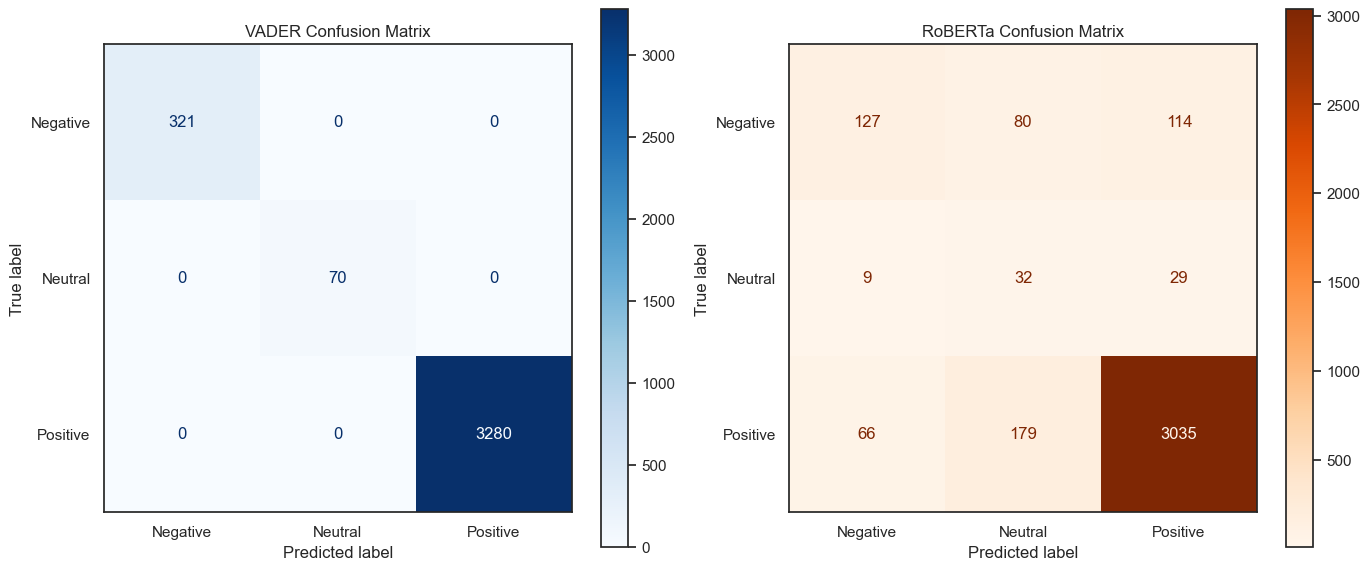

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define true and predicted labels
true_labels = results_df['VaderAnalysis']
vader_preds = results_df['VaderAnalysis']  # Self comparison
roberta_preds = results_df['RoBERTaAnalysis']

# Confusion matrices
vader_cm = confusion_matrix(true_labels, vader_preds, labels=['Negative', 'Neutral', 'Positive'])
roberta_cm = confusion_matrix(true_labels, roberta_preds, labels=['Negative', 'Neutral', 'Positive'])

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VADER
disp_vader = ConfusionMatrixDisplay(confusion_matrix=vader_cm,
                                    display_labels=['Negative', 'Neutral', 'Positive'])
disp_vader.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("VADER Confusion Matrix")

# RoBERTa
disp_roberta = ConfusionMatrixDisplay(confusion_matrix=roberta_cm,
                                      display_labels=['Negative', 'Neutral', 'Positive'])
disp_roberta.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title("RoBERTa Confusion Matrix")

plt.tight_layout()
plt.show()


C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\455364466.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sent = results_df.groupby(['ShortMonth', 'RoBERTaAnalysis']).size().reset_index(name='count')


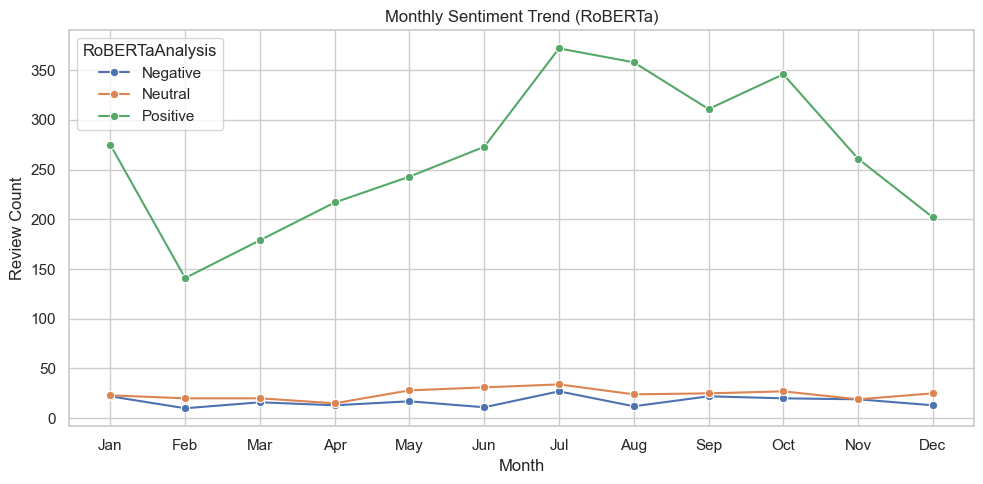

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Abbreviate months to 3-letter format
month_abbr = {
    'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr',
    'May': 'May', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
    'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'
}
results_df['ShortMonth'] = results_df['Month'].map(month_abbr)

# Group by shortened month and sentiment
monthly_sent = results_df.groupby(['ShortMonth', 'RoBERTaAnalysis']).size().reset_index(name='count')

# Optional: Sort the months properly
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sent['ShortMonth'] = pd.Categorical(monthly_sent['ShortMonth'], categories=month_order, ordered=True)
monthly_sent.sort_values('ShortMonth', inplace=True)

# Plot
plt.figure(figsize=(10, 5))  # Adjusted size for Word page
sns.set(style="whitegrid")  # Adds gridlines
sns.lineplot(data=monthly_sent, x='ShortMonth', y='count', hue='RoBERTaAnalysis', marker='o')

plt.title('Monthly Sentiment Trend (RoBERTa)', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


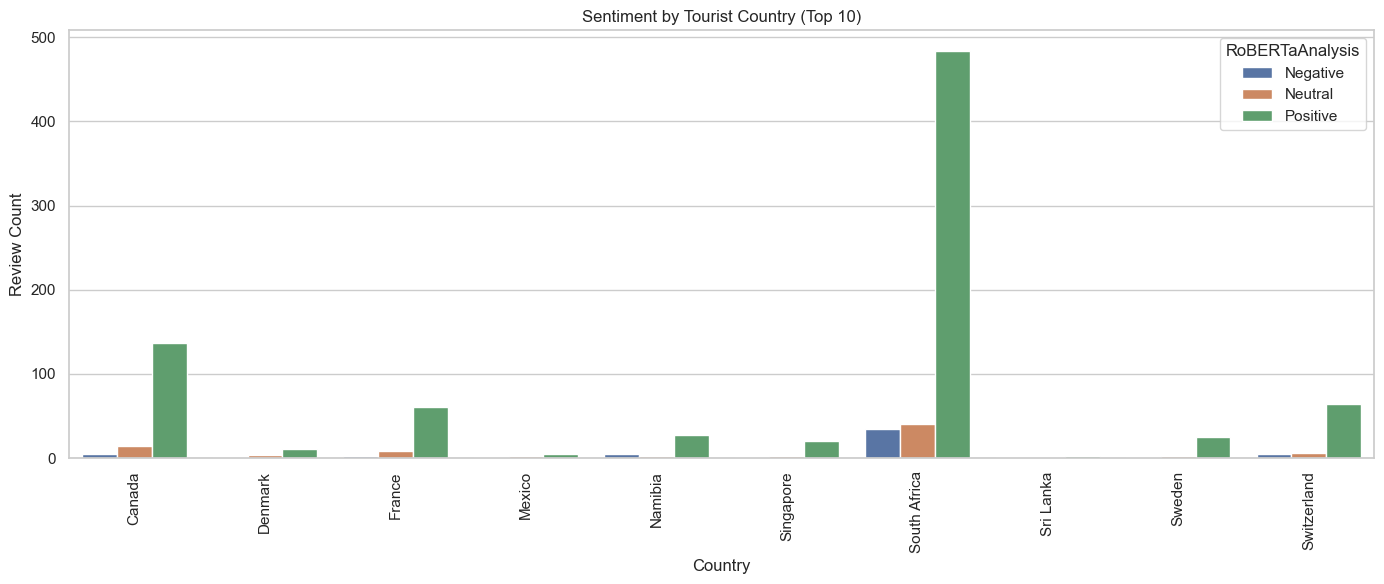

In [164]:
# 2. Sentiment by Tourist Country
sent_by_country = results_df.groupby(['tourist_country', 'RoBERTaAnalysis']).size().reset_index(name='count')
top_countries = sent_by_country['tourist_country'].value_counts().nlargest(10).index
sent_by_country_top = sent_by_country[sent_by_country['tourist_country'].isin(top_countries)]
plt.figure(figsize=(14, 6))
sns.barplot(data=sent_by_country_top, x='tourist_country', y='count', hue='RoBERTaAnalysis')
plt.xticks(rotation=90)
plt.title('Sentiment by Tourist Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

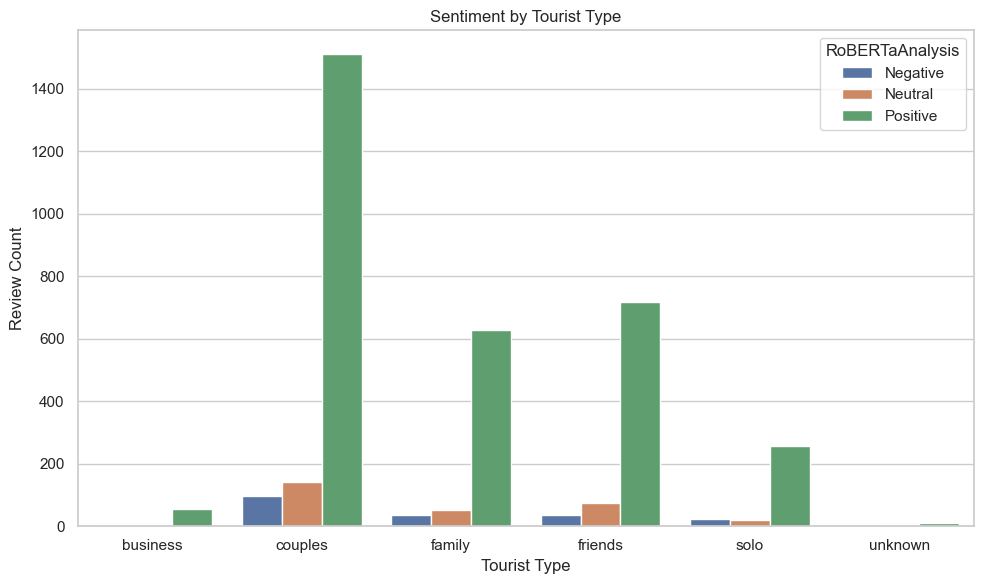

In [165]:
# 3. Sentiment by Tourist Type
sent_by_type = results_df.groupby(['tourist_type', 'RoBERTaAnalysis']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=sent_by_type, x='tourist_type', y='count', hue='RoBERTaAnalysis')
plt.title('Sentiment by Tourist Type')
plt.xlabel('Tourist Type')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

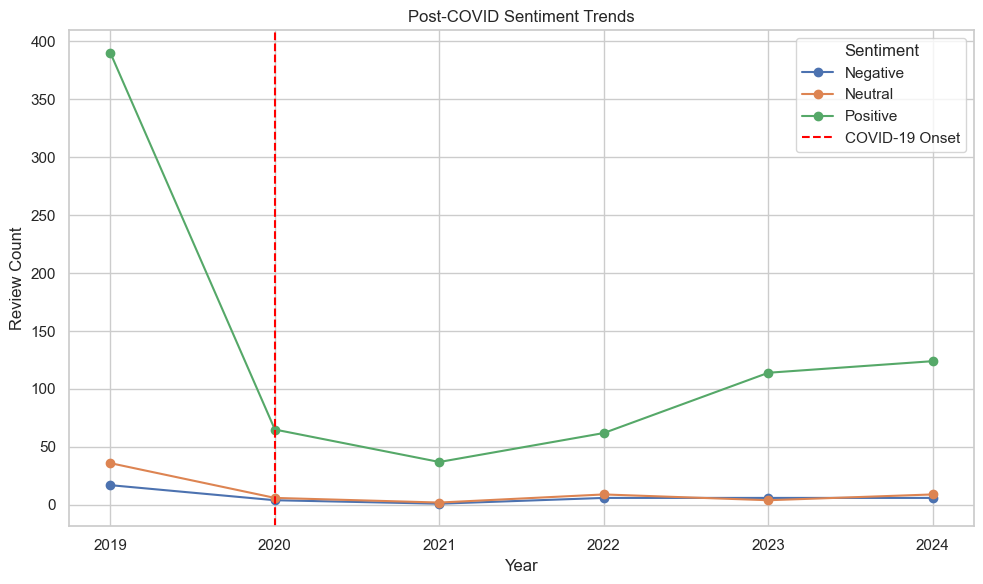

In [166]:
post_covid_df = results_df[results_df['Year'] >= 2019]
post_covid_sentiment = post_covid_df.groupby(['Year', 'RoBERTaAnalysis']).size().unstack().fillna(0)

post_covid_sentiment.plot(figsize=(10, 6), marker='o')
plt.axvline(x=2020, color='red', linestyle='--', label='COVID-19 Onset')
plt.title('Post-COVID Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


C:\Users\jshoo\AppData\Local\Temp\ipykernel_20056\183639820.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=results_df, x='RoBERTaAnalysis', palette='Set2')


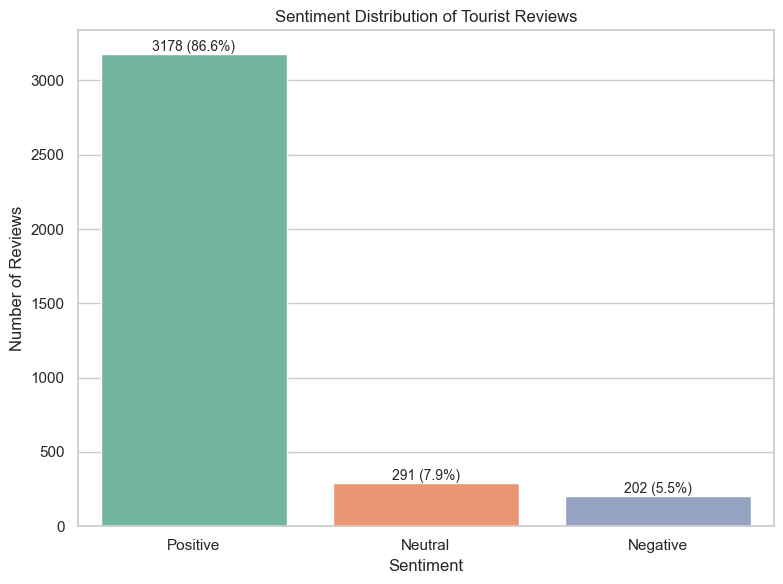

In [167]:
# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=results_df, x='RoBERTaAnalysis', palette='Set2')

# Calculate total number of reviews
total = len(results_df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{count} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Final touches
plt.title('Sentiment Distribution of Tourist Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()


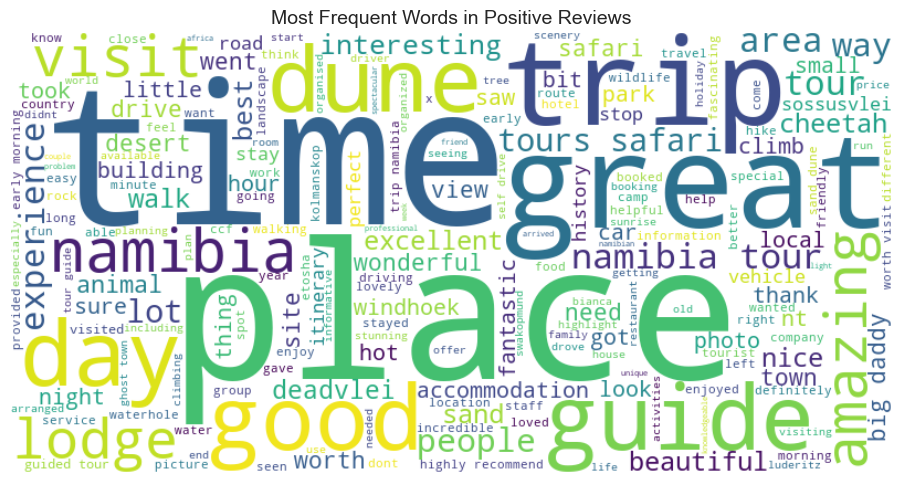

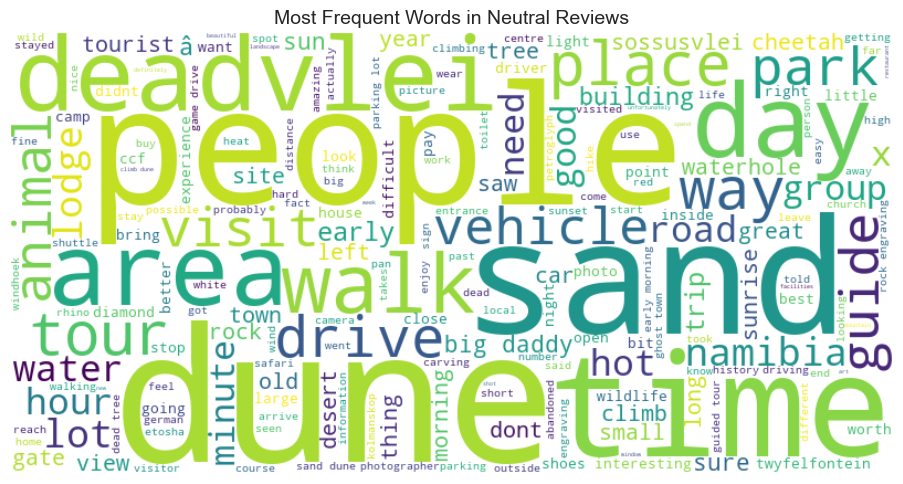

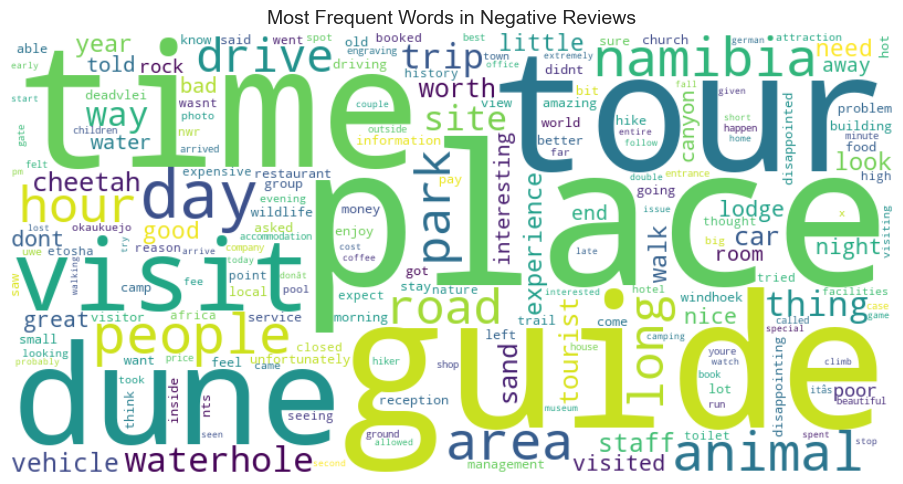

In [176]:
# 6. Word Frequency by Sentiment
def get_wordcloud(text, title, color='viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

for sentiment in ['Positive', 'Neutral', 'Negative']:
    filtered = results_df[results_df['RoBERTaAnalysis'] == sentiment]['CleanedReviews']
    get_wordcloud(filtered, f'Most Frequent Words in {sentiment} Reviews')


In [177]:
# Save the DataFrame as a CSV in the same directory as the notebook
results_df.to_csv('results_df.csv', index=False)

print("File saved successfully in the notebook folder as 'results_df.csv'")


File saved successfully in the notebook folder as 'results_df.csv'
